In [65]:
# Data collected on Jan 23, 2023

In [67]:
"""
STATE: AL
POLICY: Parole Grant Rates
VERSION: V1
DATA SOURCE: Public AL reports
DATA QUALITY: medium-low
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

data_path = "./data"

# Get the simulation tag from the model inputs config
yaml_file_path = "al_parole_grant_rate_v1.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [68]:
disaggregation_axes = simulation_config.get()["disaggregation_axes"]

In [69]:
percent_prison_pop = 0.675
violent_nonv_parole = pd.DataFrame(
    {
        "crime_type": ["violent", "nonviolent"],
        "parole_eligibility_percent": [0.85, 1 / 3],
        "max_months_to_parole": [15 * 12, 10 * 12],
        "percent_prison_pop": [percent_prison_pop, 1 - percent_prison_pop],
    }
)

violent_pop = violent_nonv_parole[["crime_type", "percent_prison_pop"]]

In [70]:
violent_pop

,crime_type,percent_prison_pop
0,violent,0.675
1,nonviolent,0.325


In [71]:
violent_nonv_parole.crime_type

0       violent
1    nonviolent
Name: crime_type, dtype: object

# PAROLE DATA SETUP

In [72]:
al_month_parole = pd.read_csv(
    "./data/AL Parole Board Grant Rates - Monthly Reports.csv",
    comment="#",
    parse_dates=["Month"],
)

al_month_parole.category1.fillna(method="ffill", inplace=True)
al_month_parole.Month.fillna(method="ffill", inplace=True)
al_month_parole.category2 = al_month_parole.category2.mask(
    al_month_parole.category1 == "Totals", "Totals"
)

for col in ["Rate", "Rate - Guideline", "Conform"]:
    al_month_parole[col] = al_month_parole[col].str.rstrip("%").astype("float") / 100.0

al_grant_rates_by_month = al_month_parole[
    al_month_parole.category2.isin(["Totals", "Violent", "Non-violent"])
]
# hacky interpolation to fill missing report for Feb 2022
al_grant_rates_by_month = pd.concat(
    [
        al_grant_rates_by_month.Month,
        al_grant_rates_by_month.groupby("category2", group_keys=False).apply(
            lambda x: x[
                [
                    "category2",
                    "Decisions",
                    "Grant",
                    "Deny",
                    "Rate",
                    "Grant - Guideline",
                    "Deny - Guideline",
                    "Rate - Guideline",
                    "Conform",
                ]
            ].interpolate()
        ),
    ],
    axis=1,
)

al_grant_rates_by_month["Year"] = al_grant_rates_by_month.Month.dt.year
al_grant_rates_by_month_total = al_grant_rates_by_month[
    al_grant_rates_by_month.category2 == "Totals"
]

<Axes: xlabel='Month'>

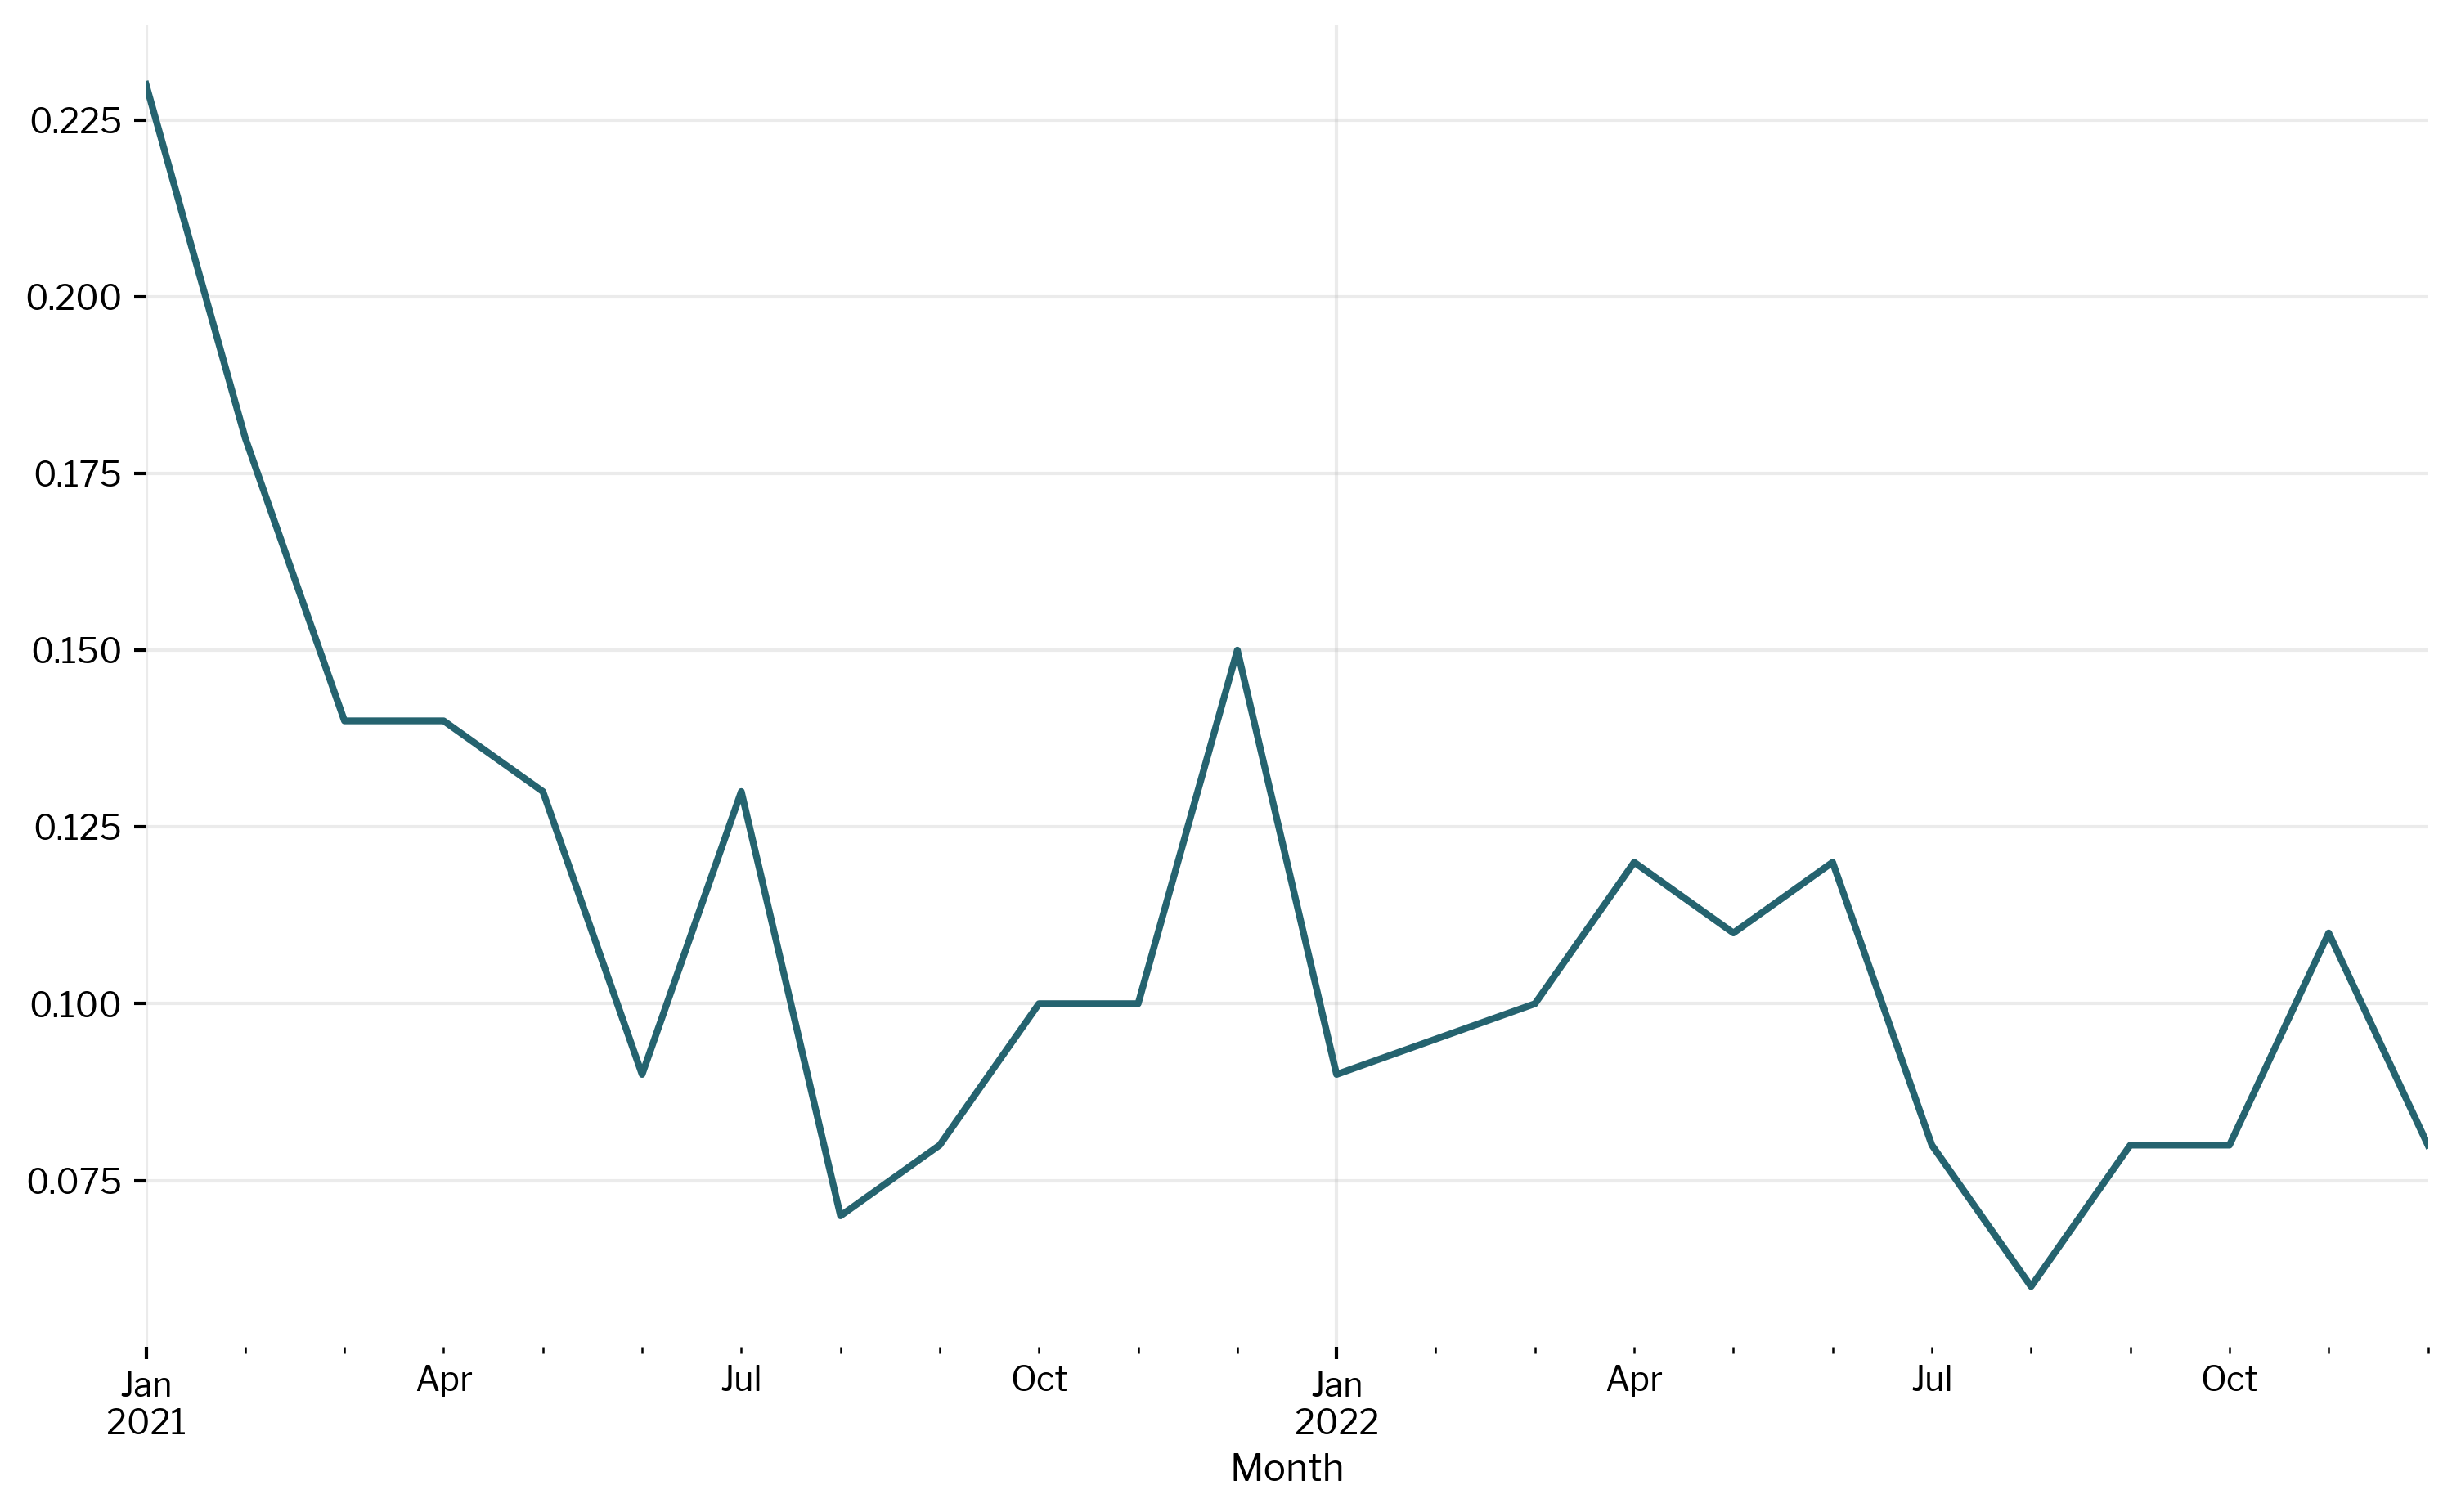

In [73]:
al_grant_rates_by_month_total.set_index("Month").Rate.plot()
# plt.xlim(pd.to_datetime("2017"))

In [74]:
# al_grant_rates_by_month_total

In [145]:
parole_rev = pd.read_csv(
    "./data/AL Parole Board Grant Rates - Parole Revocations.csv",
    parse_dates=["Month"],
)

parole_rev = parole_rev.dropna(how="all", axis=0).rename(
    columns={"Monthly Totals": "revocations"}
)
parole_rev = parole_rev[parole_rev["Revocation"] == "Revoked"].set_index("Month")[
    ["revocations"]
]
parole_rev.mean()

revocations    78.625
dtype: float64

# TOTAL POPULATION

In [76]:
parole_pop = pd.read_csv(
    "./data/AL Prison_Parole Raw Data - Parole population.csv",
    comment="#",
    parse_dates=["Month"],
    usecols=["util", "Month", "Supervision Type", "Total by Type Offenders"],
    dtype={"Total by Type Offenders": float},
)
parole_pop.Month.fillna(method="ffill", inplace=True)

parole_pop = parole_pop[parole_pop.util == "Parole"]
parole_pop = parole_pop[
    (parole_pop["Supervision Type"] == "Violent")
    | (parole_pop["Supervision Type"] == "Non-Violent")
]

parole_pop["crime_type"] = (
    parole_pop["Supervision Type"]
    .str.lower()
    .where(parole_pop["Supervision Type"] == "Violent", "nonviolent")
)

parole_pop = parole_pop.rename(
    columns={"Total by Type Offenders": "total_population"}
).drop(columns=["Supervision Type", "util"])
parole_pop["compartment"] = "parole"
parole_pop.tail()

,total_population,Month,crime_type,compartment
610,2274.0,2022-10-01,nonviolent,parole
639,3298.0,2022-11-01,violent,parole
640,2260.0,2022-11-01,nonviolent,parole
669,3269.0,2022-12-01,violent,parole
670,2266.0,2022-12-01,nonviolent,parole


In [167]:
prison_pop = pd.read_csv(
    "./data/AL Prison_Parole Data - DOC prison population.csv",
    parse_dates=["Month"],
    thousands=",",
    usecols=["Month", "ADOC CUSTODY POPULATION"],
    dtype={"ADOC CUSTODY POPULATION": float},
).rename(columns={"ADOC CUSTODY POPULATION": "total_population"})
prison_poppp = prison_pop.set_index("Month")
prison_poppp.loc[pd.to_datetime("2022-12-01")] = 20640
prison_poppp.loc[pd.to_datetime("2023-01-01")] = 20608
# prison_poppp.loc[pd.date_range("2017-12-01", "2022-12-01", freq="AS-DEC")] / 21570
# prison_poppp.loc[pd.date_range("2017-12-01", "2022-12-01", freq="MS")] / 21570
# prison_pop.l

In [77]:
prison_pop["revocation_portion"] = 1 - 6597 / prison_pop.total_population.iloc[-1]
prison_pop.total_population = (
    prison_pop.total_population * prison_pop.revocation_portion
)
prison_pop.drop(columns="revocation_portion", inplace=True)

In [78]:
prison_pop.tail()

,Month,total_population
66,2022-07-01,13996.453887
67,2022-08-01,13933.281346
68,2022-09-01,13976.075648
69,2022-10-01,14012.077204
70,2022-11-01,13972.000000


In [79]:
prison_pop_vnv = pd.merge(prison_pop, violent_pop, how="cross")

prison_pop_vnv.total_population = (
    prison_pop_vnv.total_population * prison_pop_vnv.percent_prison_pop
)
prison_pop = prison_pop_vnv.drop(columns="percent_prison_pop")
prison_pop["compartment"] = "prison"

In [80]:
total_population = pd.concat([prison_pop, parole_pop]).set_index("Month")
total_population.head()

,total_population,crime_type,compartment
Month,,,
2017-01-01,10620.934435,violent,prison
2017-01-01,5113.783247,nonviolent,prison
2017-02-01,10585.629136,violent,prison
2017-02-01,5096.784399,nonviolent,prison
2017-03-01,10465.040906,violent,prison


# OUTFLOWS

In [81]:
doc_all_admissions = pd.read_csv(
    "./data/AL Prison_Parole Raw Data - DOC admissions.csv",
    parse_dates=["Month"],
    usecols=[
        "Month",
        "New Commitment",
        "Parole Re-admissions",
        "End of Sentence",
        "Paroles Granted",
        "Parole Releases",
        "Mandatory Release",
    ],
).rename(
    columns={
        "New Commitment": "new_commitment",
        "Parole Re-admissions": "parole_readmission",
        "End of Sentence": "end_of_sentence",
        "Paroles Granted": "parole_granted",
        "Parole Releases": "parole_release",
        "Mandatory Release": "mandatory_release",
    }
)
doc_all_admissions[
    "release_to_liberty"
] = doc_all_admissions.end_of_sentence + doc_all_admissions.mandatory_release.fillna(0)

In [82]:
outflows = (
    doc_all_admissions.drop(
        columns=["parole_granted", "end_of_sentence", "mandatory_release"]
    )
    .set_index("Month")
    .melt(var_name="admission_type", value_name="total_population", ignore_index=False)
    .reset_index()
)
# outflows.head()

In [83]:
outflow_mappings = pd.DataFrame(
    [
        ["new_commitment", "pretrial", "prison"],
        ["parole_release", "prison", "parole"],
        ["release_to_liberty", "prison", "liberty"],
        ["parole_readmission", "parole", "prisonrev"],
    ],
    columns=["admission_type", "compartment", "outflow_to"],
)
outflow_mappings

,admission_type,compartment,outflow_to
0,new_commitment,pretrial,prison
1,parole_release,prison,parole
2,release_to_liberty,prison,liberty
3,parole_readmission,parole,prisonrev


In [84]:
outflows_with_type = pd.merge(outflows, outflow_mappings)
outflows_vnv = pd.merge(
    outflows_with_type.drop(columns="admission_type"), violent_pop, how="cross"
)

outflows_vnv.total_population = (
    outflows_vnv.total_population * outflows_vnv.percent_prison_pop
)
outflows = outflows_vnv.drop(columns="percent_prison_pop")

In [85]:
outflows_with_type.sort_values(by=["Month", "admission_type"]).tail()

,Month,admission_type,total_population,compartment,outflow_to
282,2022-10-01,release_to_liberty,339.0,prison,liberty
70,2022-11-01,new_commitment,223.0,pretrial,prison
141,2022-11-01,parole_readmission,76.0,parole,prisonrev
212,2022-11-01,parole_release,36.0,prison,parole
283,2022-11-01,release_to_liberty,404.0,prison,liberty


<Axes: xlabel='Month'>

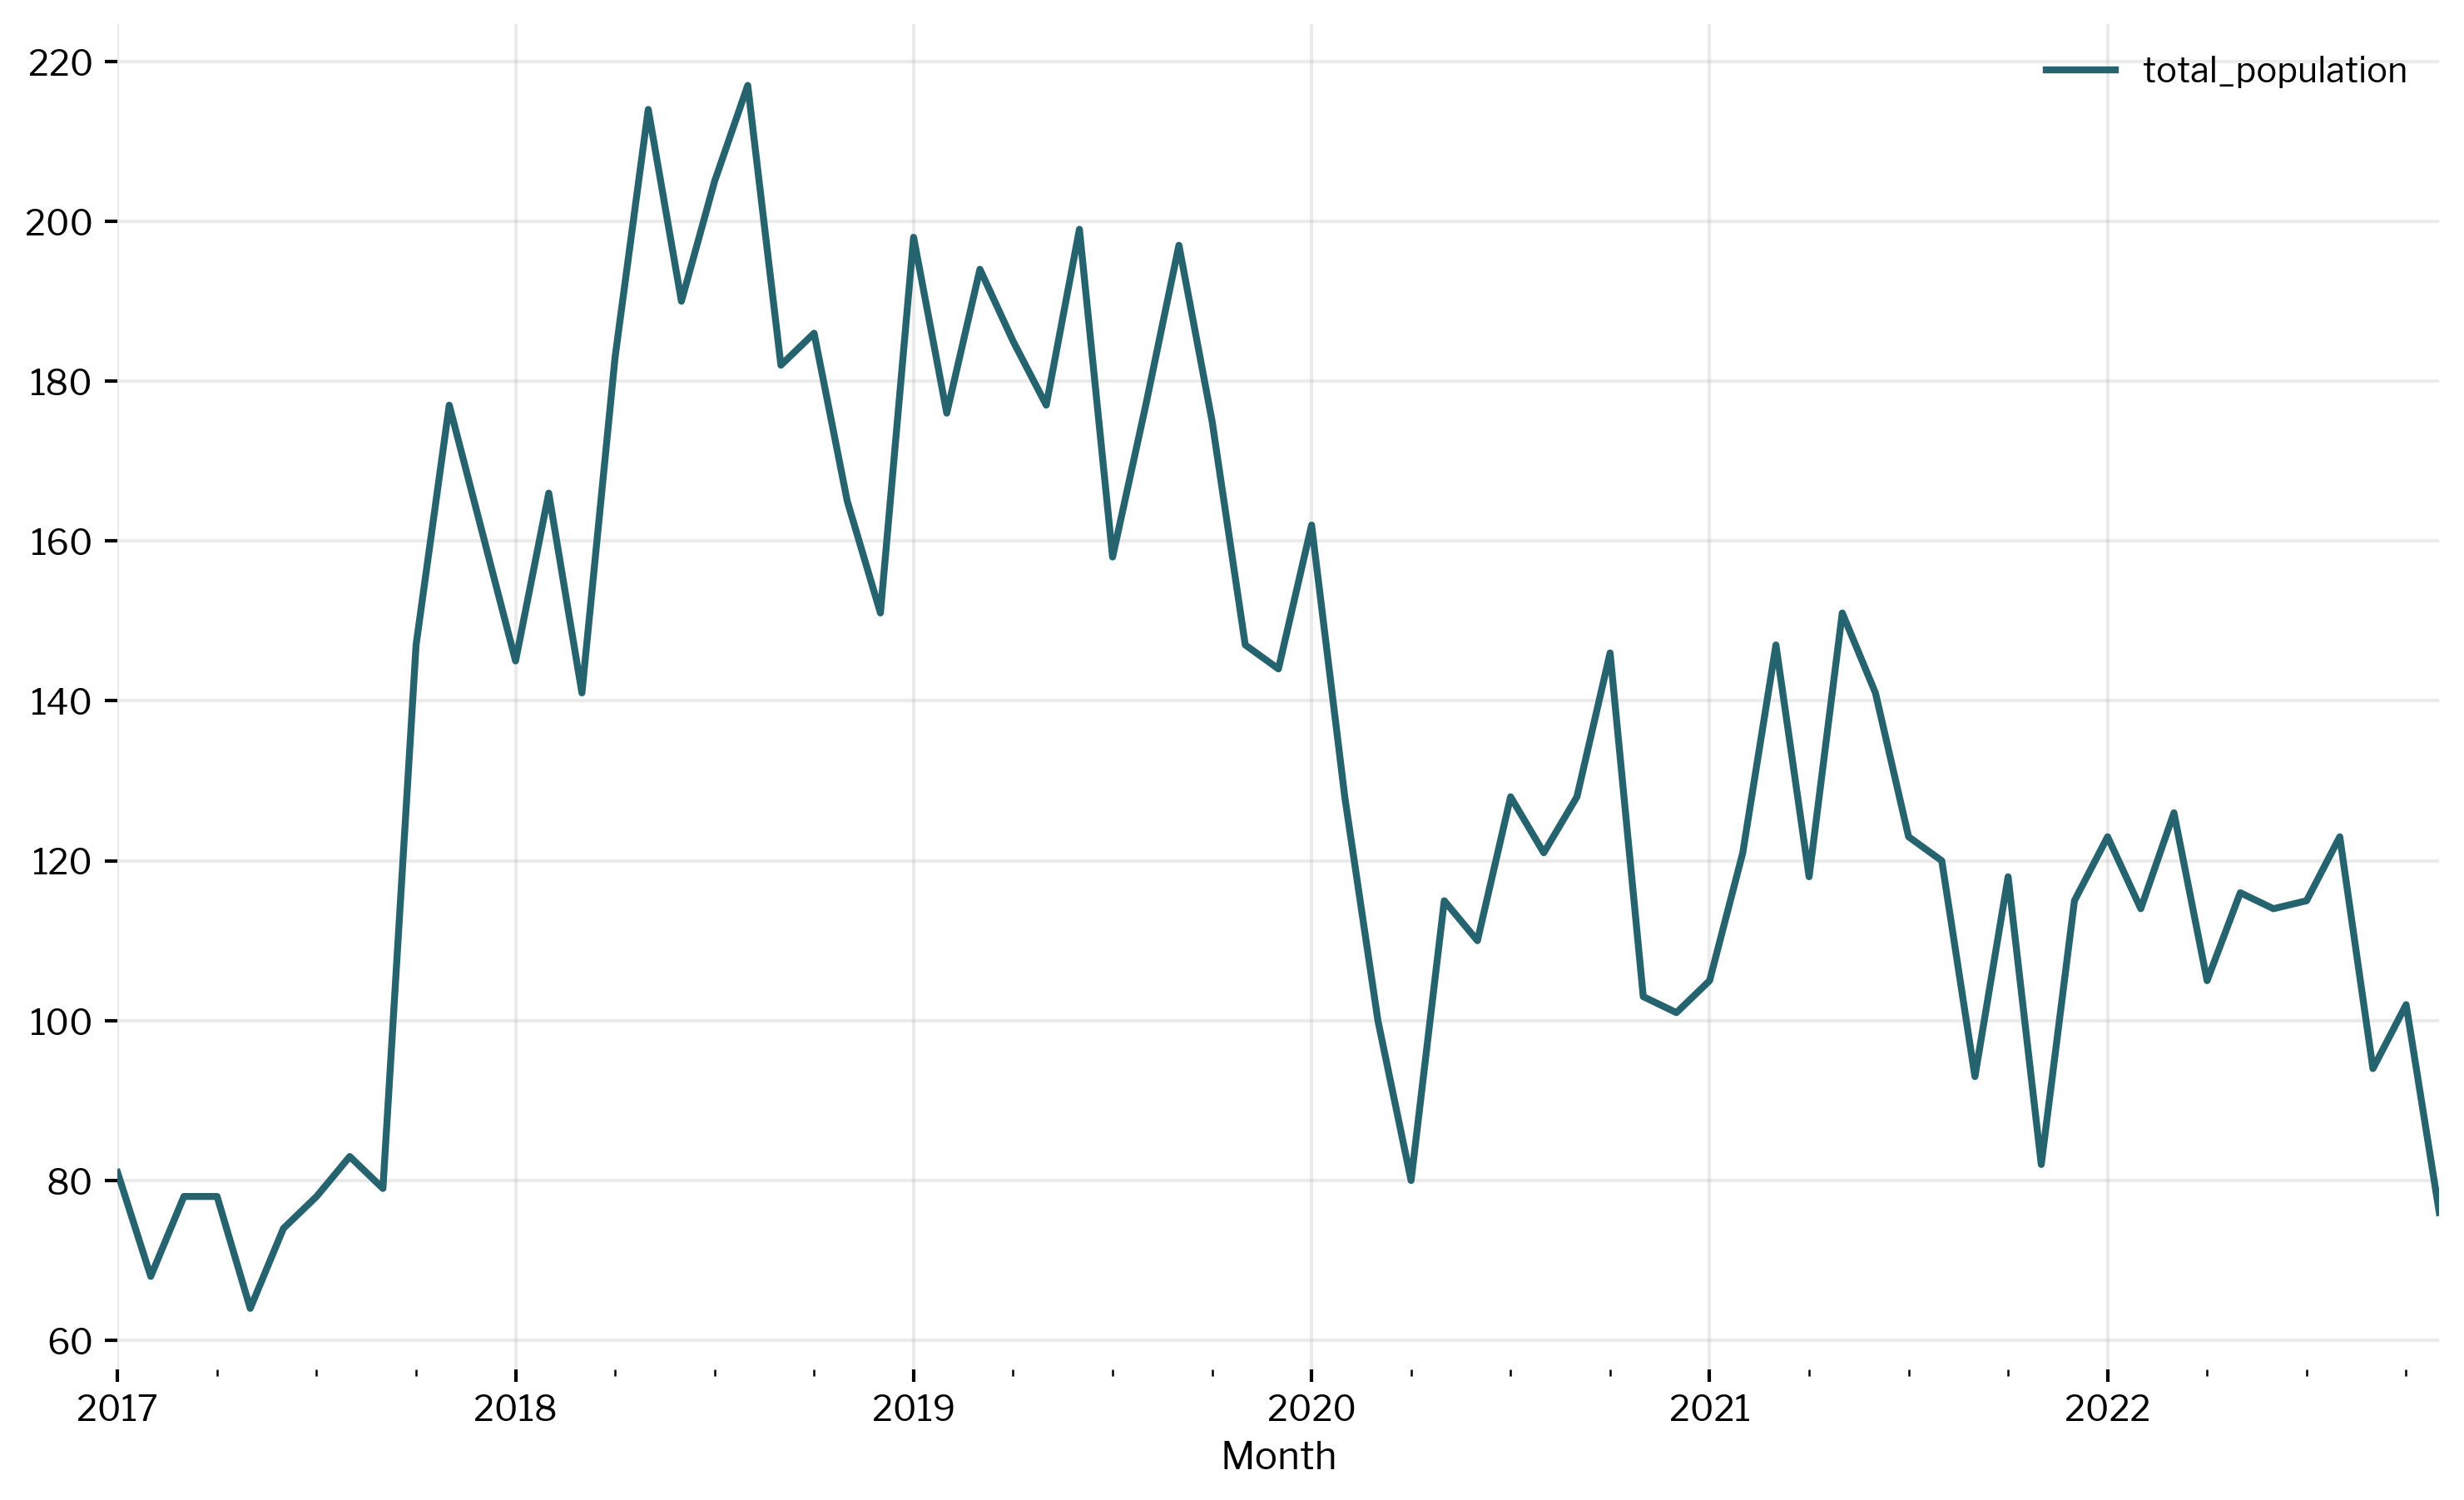

In [147]:
outflows_with_type[outflows_with_type.admission_type == "parole_readmission"].set_index(
    "Month"
).plot()

# TRANSTIIONS 

In [86]:
doc_los = pd.read_csv(
    "./data/AL Prison_Parole Raw Data - DOC Length of stay dist.csv",
    thousands=",",
)

doc_los["sentence_bin_start"] = doc_los.max_sentence_bin.shift(1, fill_value=0)
doc_los["bin_month_length"] = (
    np.floor((doc_los.max_sentence_bin - doc_los.sentence_bin_start) * 12)
).clip(lower=1)
doc_los["bin_month_end"] = doc_los.bin_month_length.cumsum()
doc_los["pop_in_month_bin"] = doc_los.Total / doc_los.bin_month_length

doc_los.set_index("bin_month_end", inplace=True)
#
# Chop sentences at 25 years
#
doc_los = doc_los.reindex(np.arange(1, 300), method="backfill")
# doc_los = doc_los.reindex(np.arange(1, max(doc_los.index) + 1), method="backfill")
doc_los.index.rename("raw_sentence_months", inplace=True)

### calibration knobs

In [87]:
# calibrate to match prison outflows
# doc_los.loc[6, "pop_in_month_bin"] = 2000
# doc_los.loc[12, "pop_in_month_bin"] = 2000

<Axes: xlabel='raw_sentence_months'>

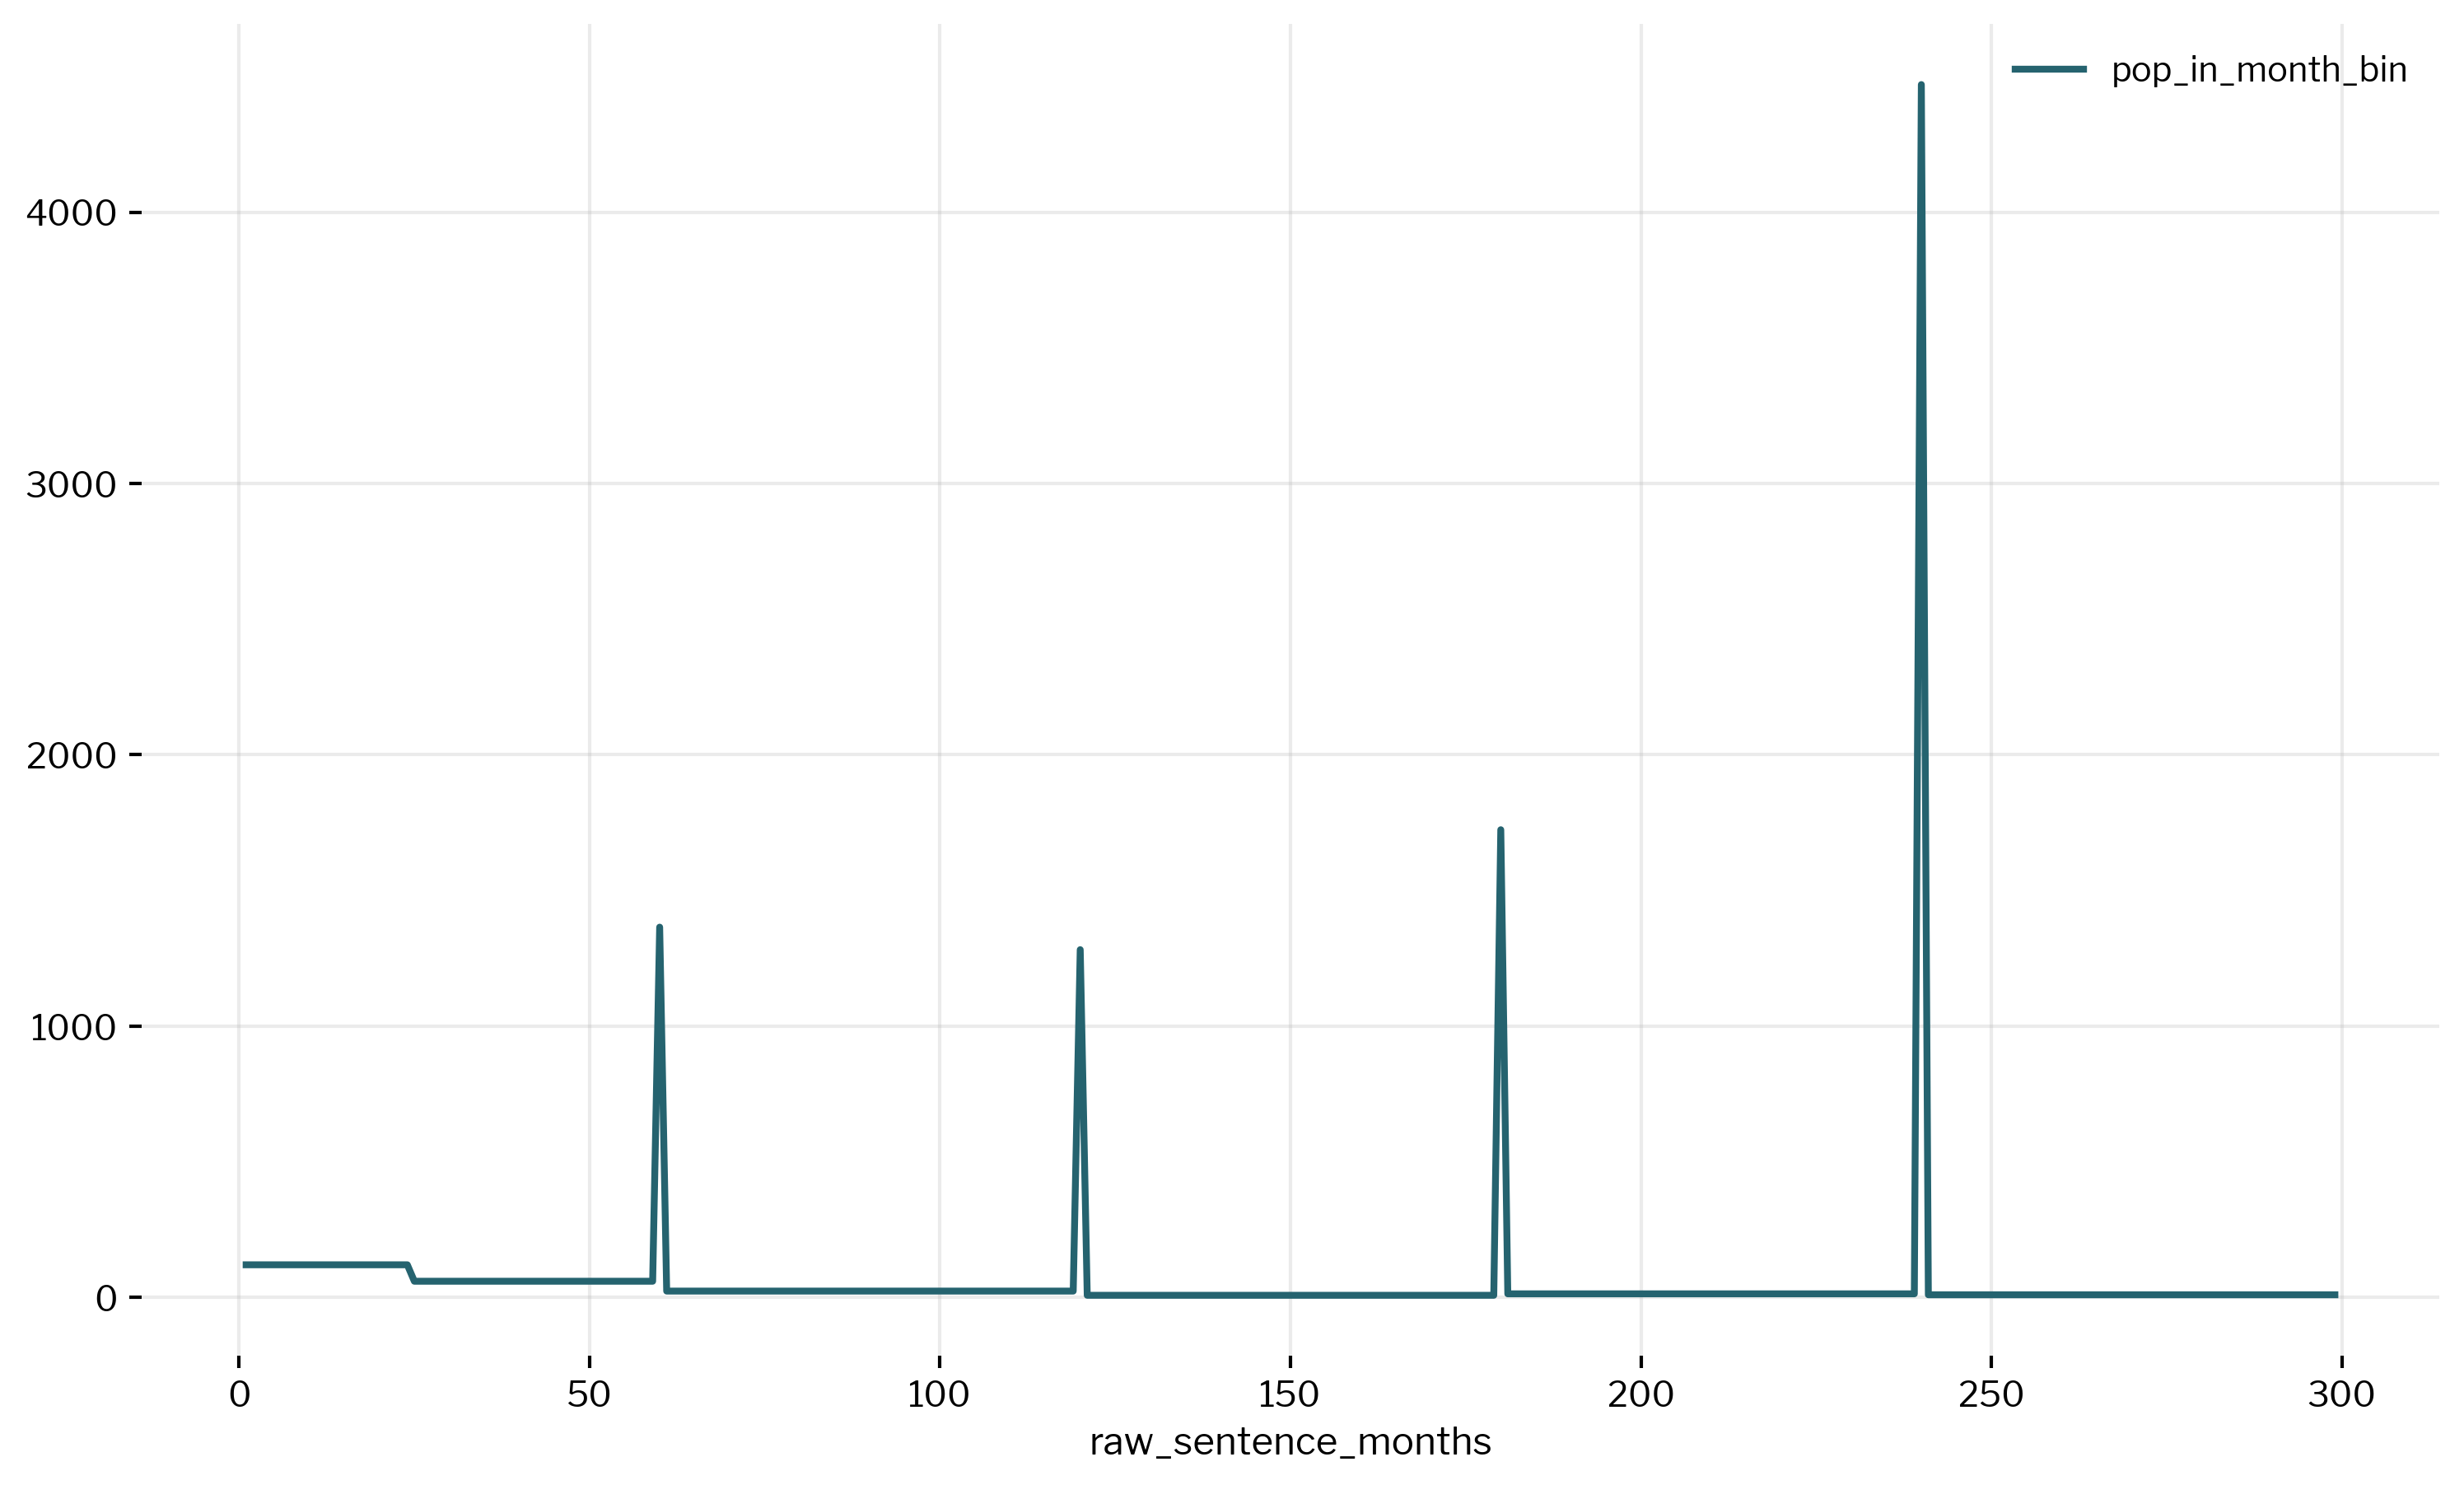

In [88]:
doc_los[["pop_in_month_bin"]].plot()

In [89]:
prison_transitions_to_parole = doc_los[["pop_in_month_bin"]].reset_index()
prison_transitions_to_parole.head()

,raw_sentence_months,pop_in_month_bin
0,1,120.75
1,2,120.75
2,3,120.75
3,4,120.75
4,5,120.75


In [90]:
# redistribute nonviolent LOS
prison_trans_to_parole = pd.merge(
    prison_transitions_to_parole, violent_nonv_parole.crime_type, how="cross"
)
prison_trans_to_parole["sen_bin"] = pd.cut(
    prison_trans_to_parole.raw_sentence_months,
    bins=[0, 24, 60, 120, 999],
    labels=["0-23", "24-59", "60-119", "120+"],
    right=False,
)
# prison_trans_to_parole.groupby(['crime_type','sen_bin']).count()
display(prison_trans_to_parole.groupby(["crime_type"]).sum())
display(prison_trans_to_parole.groupby(["crime_type", "sen_bin"]).sum())
display(
    prison_trans_to_parole.groupby(["crime_type", "sen_bin"]).sum()
    / prison_trans_to_parole.groupby("crime_type").sum()
)
# violent_nonv_parole.crime_type
long_nv_sentences_to_move_to_short_bin = (
    0.2
    * prison_trans_to_parole[
        (prison_trans_to_parole.crime_type == "nonviolent")
        & (prison_trans_to_parole.sen_bin == "120+")
    ].pop_in_month_bin.sum()
)
nv_short_bin_adj = (
    long_nv_sentences_to_move_to_short_bin
    / prison_trans_to_parole[
        prison_trans_to_parole.sen_bin == "0-23"
    ].raw_sentence_months.nunique()
)
prison_trans_to_parole.pop_in_month_bin = prison_trans_to_parole.pop_in_month_bin.mask(
    (prison_trans_to_parole.crime_type == "nonviolent")
    & (prison_trans_to_parole.sen_bin == "120+"),
    0.8 * prison_trans_to_parole.pop_in_month_bin,
)
prison_trans_to_parole.pop_in_month_bin = prison_trans_to_parole.pop_in_month_bin.mask(
    (prison_trans_to_parole.crime_type == "nonviolent")
    & (prison_trans_to_parole.sen_bin == "0-23"),
    nv_short_bin_adj + prison_trans_to_parole.pop_in_month_bin,
)

display(prison_trans_to_parole.groupby(["crime_type"]).sum())
display(prison_trans_to_parole.groupby(["crime_type", "sen_bin"]).sum())
display(
    prison_trans_to_parole.groupby(["crime_type", "sen_bin"]).sum()
    / prison_trans_to_parole.groupby("crime_type").sum()
)

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3502/2341739794.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(prison_trans_to_parole.groupby(["crime_type"]).sum())


,raw_sentence_months,pop_in_month_bin
crime_type,,
nonviolent,44850,17157.0
violent,44850,17157.0


raw_sentence_months  pop_in_month_bin
crime_type sen_bin                                       
nonviolent 0-23                     276           2777.25
           24-59                   1494           2224.75
           60-119                  5370           2771.00
           120+                   37710           9384.00
violent    0-23                     276           2777.25
           24-59                   1494           2224.75
           60-119                  5370           2771.00
           120+                   37710           9384.00

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3502/2341739794.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  / prison_trans_to_parole.groupby("crime_type").sum()


raw_sentence_months  pop_in_month_bin
crime_type sen_bin                                       
nonviolent 0-23                0.006154          0.161873
           24-59               0.033311          0.129670
           60-119              0.119732          0.161508
           120+                0.840803          0.546949
violent    0-23                0.006154          0.161873
           24-59               0.033311          0.129670
           60-119              0.119732          0.161508
           120+                0.840803          0.546949

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3502/2341739794.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(prison_trans_to_parole.groupby(["crime_type"]).sum())


,raw_sentence_months,pop_in_month_bin
crime_type,,
nonviolent,44850,17157.0
violent,44850,17157.0


raw_sentence_months  pop_in_month_bin
crime_type sen_bin                                       
nonviolent 0-23                     276           4654.05
           24-59                   1494           2224.75
           60-119                  5370           2771.00
           120+                   37710           7507.20
violent    0-23                     276           2777.25
           24-59                   1494           2224.75
           60-119                  5370           2771.00
           120+                   37710           9384.00

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3502/2341739794.py:47: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  / prison_trans_to_parole.groupby("crime_type").sum()


raw_sentence_months  pop_in_month_bin
crime_type sen_bin                                       
nonviolent 0-23                0.006154          0.271262
           24-59               0.033311          0.129670
           60-119              0.119732          0.161508
           120+                0.840803          0.437559
violent    0-23                0.006154          0.161873
           24-59               0.033311          0.129670
           60-119              0.119732          0.161508
           120+                0.840803          0.546949

In [91]:
prison_trans_to_parole.head()

,raw_sentence_months,pop_in_month_bin,crime_type,sen_bin
0,1,120.75,violent,0-23
1,1,202.35,nonviolent,0-23
2,2,120.75,violent,0-23
3,2,202.35,nonviolent,0-23
4,3,120.75,violent,0-23


In [92]:
prison_trans_to_parole = pd.merge(
    prison_transitions_to_parole, violent_nonv_parole, how="cross"
)
prison_trans_to_parole["adjusted_sen_months"] = (
    prison_trans_to_parole.raw_sentence_months
    * prison_trans_to_parole.parole_eligibility_percent
)
prison_trans_to_parole["adjusted_duration_months_vnv"] = prison_trans_to_parole[
    ["adjusted_sen_months", "max_months_to_parole"]
].min(axis=1)
prison_trans_to_parole["adjusted_pop"] = (
    prison_trans_to_parole.pop_in_month_bin * prison_trans_to_parole.percent_prison_pop
)

prison_trans_to_parole = prison_trans_to_parole.drop(
    columns=[
        "parole_eligibility_percent",
        "max_months_to_parole",
        "adjusted_sen_months",
    ]
)

In [93]:
prison_trans_to_parole.head()

,raw_sentence_months,pop_in_month_bin,crime_type,percent_prison_pop,adjusted_duration_months_vnv,adjusted_pop
0,1,120.75,violent,0.675,0.850000,81.50625
1,1,120.75,nonviolent,0.325,0.333333,39.24375
2,2,120.75,violent,0.675,1.700000,81.50625
3,2,120.75,nonviolent,0.325,0.666667,39.24375
4,3,120.75,violent,0.675,2.550000,81.50625


In [94]:
def prison_to_parole_outcomes(prison_sen):
    parole_outcomes = pd.DataFrame(
        {
            "compartment": ["prison", "prison", "parole"],
            "outflow_to": ["liberty", "parole", "liberty"],
            "compartment_duration_raw": [
                float(prison_sen.raw_sentence_months),
                float(prison_sen.adjusted_duration_months_vnv),
                float(
                    prison_sen.raw_sentence_months
                    - prison_sen.adjusted_duration_months_vnv
                ),
            ],
        }
    )
    return pd.merge(prison_sen, parole_outcomes, how="cross").drop(
        columns=["raw_sentence_months", "crime_type"]
    )


los = (
    # groupby every row (every month duration, violent/nonv)
    prison_trans_to_parole.groupby(["raw_sentence_months", "crime_type"])
    .apply(prison_to_parole_outcomes)
    .reset_index()
    .drop(columns="level_2")
)
los["compartment_duration"] = np.floor(los.compartment_duration_raw).clip(lower=1)
los.head()

,raw_sentence_months,crime_type,pop_in_month_bin,percent_prison_pop,adjusted_duration_months_vnv,adjusted_pop,compartment,outflow_to,compartment_duration_raw,compartment_duration
0,1,nonviolent,120.75,0.325,0.333333,39.24375,prison,liberty,1.000000,1.0
1,1,nonviolent,120.75,0.325,0.333333,39.24375,prison,parole,0.333333,1.0
2,1,nonviolent,120.75,0.325,0.333333,39.24375,parole,liberty,0.666667,1.0
3,1,violent,120.75,0.675,0.850000,81.50625,prison,liberty,1.000000,1.0
4,1,violent,120.75,0.675,0.850000,81.50625,prison,parole,0.850000,1.0


### transition methods

In [95]:
def get_parole_release_rate_df(grant_rate: float) -> pd.DataFrame:
    parole_release_rate = grant_rate
    display(f"parole release rate = {parole_release_rate}")
    parole_release_rates = pd.DataFrame(
        {
            "compartment": ["prison", "prison", "parole"],
            "outflow_to": ["liberty", "parole", "liberty"],
            "proportion_parole": [
                float(1 - parole_release_rate),
                float(parole_release_rate),
                float(parole_release_rate),
            ],
        }
    )
    parole_release_rates["grant_rate"] = grant_rate
    return parole_release_rates

In [96]:
def get_base_transitions(los, grant_rate):
    transitions_w_parole_release_rate = pd.merge(
        los,
        get_parole_release_rate_df(grant_rate),
        how="inner",
        on=["compartment", "outflow_to"],
    ).reset_index(drop=True)

    transitions_w_parole_release_rate["total_population"] = (
        transitions_w_parole_release_rate.adjusted_pop
        * transitions_w_parole_release_rate.proportion_parole
    )

    transitions_w_parole_release_rate_grouped = (
        transitions_w_parole_release_rate.groupby(
            [
                "grant_rate",
                "compartment",
                "outflow_to",
                "crime_type",
                "compartment_duration",
            ]
        )[["total_population"]]
        .sum()
        .sort_values(by="compartment_duration")
        .reset_index()
    )

    #     plot
    #     transitions_w_parole_release_rate_grouped[transitions_w_parole_release_rate_grouped.compartment == "parole"].groupby(
    #         ["outflow_to", "compartment_duration", "crime_type"]
    #     )[["total_population"]].sum().reset_index().pivot(
    #         index="compartment_duration",
    #         columns=["outflow_to", "crime_type"],
    #         values="total_population",
    #     ).plot()

    #     return transitions_w_parole_release_rate_grouped

    # optional calibration:
    # clip parole transitions at 5 years

    parole_cap_months = 120
    transitions_w_parole_release_rate_parole_trimmed = (
        transitions_w_parole_release_rate_grouped[
            ~(
                (transitions_w_parole_release_rate_grouped.compartment == "parole")
                & (
                    transitions_w_parole_release_rate_grouped.compartment_duration
                    > parole_cap_months
                )
            )
        ]
    )
    return transitions_w_parole_release_rate_parole_trimmed

In [97]:
revocation_rate_per_cohort = 0.2916

In [98]:
def add_revocations_to_transitions(base_transitions):
    display(
        base_transitions[base_transitions.compartment == "parole"]
        .groupby("crime_type")
        .total_population.sum()
    )
    # calculate monthly revocs by splitting 29% of all paroles into
    # the first 36 months equally
    revocations_per_month_3yr = (
        base_transitions[base_transitions.compartment == "parole"]
        .groupby("crime_type")
        .total_population.sum()
        * revocation_rate_per_cohort
        / 36
    ).reset_index()

    parole_revs = pd.merge(
        # dummy df with revocations for each crime type
        pd.merge(
            base_transitions[["grant_rate", "compartment", "outflow_to"]].head(1),
            revocations_per_month_3yr,
            how="cross",
        ),
        pd.Series(np.arange(1.0, 37.0), name="compartment_duration", dtype="float64"),
        how="cross",
    )
    parole_revs.outflow_to = "prisonrev"

    base_transitions.total_population = base_transitions.total_population.mask(
        (base_transitions.compartment == "parole"),
        base_transitions.total_population * (1 - revocation_rate_per_cohort),
    )

    transitions_with_rev = pd.concat([base_transitions, parole_revs])
    display(
        transitions_with_rev[transitions_with_rev.compartment == "parole"]
        .groupby("crime_type")
        .total_population.sum()
    )
    return transitions_with_rev

In [99]:
def add_prisonrev_transitions(transitions):
    parole_to_liberty_transitions = transitions[
        (transitions.compartment == "parole") & (transitions.outflow_to == "liberty")
    ].copy()
    max_parole_stay = parole_to_liberty_transitions.groupby("crime_type")[
        ["compartment_duration"]
    ].max()
    display(max_parole_stay)
    display(
        parole_to_liberty_transitions.groupby("crime_type")[["total_population"]].sum()
    )
    prisonrev = pd.merge(
        parole_to_liberty_transitions,
        # reduce max prison stay after revocation by 1.5 years (avg revocation date)
        (max_parole_stay - 36) / max_parole_stay,
        how="inner",
        on="crime_type",
        suffixes=["", "_multiplier"],
    )
    prisonrev["new_compartment_duration"] = (
        prisonrev.compartment_duration * prisonrev.compartment_duration_multiplier
    ).round()
    prisonrev["duration_diff"] = (
        prisonrev.compartment_duration - prisonrev.new_compartment_duration
    )

    prisonrev.compartment_duration = (
        prisonrev.compartment_duration * prisonrev.compartment_duration_multiplier
    ).round()

    # condense new duration buckets
    prisonrev = (
        prisonrev.groupby(
            [
                "grant_rate",
                "compartment",
                "outflow_to",
                "crime_type",
                "compartment_duration",
            ]
        )[["total_population"]]
        .sum()
        .reset_index()
    )  # .drop(columns='compartment_duration_multiplier')
    display(prisonrev.groupby("crime_type")[["compartment_duration"]].max())
    prisonrev.compartment = "prisonrev"
    display(prisonrev.head())
    display(prisonrev.tail())
    transitions_with_prisonrev = pd.concat([transitions, prisonrev])
    return transitions_with_prisonrev

In [100]:
def add_manual_transitions(transitions, grant_rate):
    un = [transitions[d].unique() for d in ["crime_type"]]
    manual_combos = list(itertools.product(*un))
    min_transitions_per_compartment = len(manual_combos)

    manual_transitions = pd.DataFrame(manual_combos, columns=disaggregation_axes)
    manual_transitions["grant_rate"] = grant_rate
    manual_transitions["compartment"] = "liberty"
    manual_transitions["outflow_to"] = "liberty"
    manual_transitions["total_population"] = 1
    manual_transitions["compartment_duration"] = 1

    transitions = pd.concat([transitions, manual_transitions])
    return transitions

In [101]:
def get_transitions_with_grant_rate(los, grant_rate):
    transitions_no_rev = get_base_transitions(los, grant_rate)
    transitions_with_rev = add_revocations_to_transitions(transitions_no_rev)
    transitions_with_prisonrev = add_prisonrev_transitions(transitions_with_rev)
    transitions = add_manual_transitions(transitions_with_prisonrev, grant_rate)
    return transitions

### test transitions to check

In [102]:
test_transitions = get_transitions_with_grant_rate(los, 0.5)

'parole release rate = 0.5'

crime_type
nonviolent    1833.771186
violent       5790.487500
Name: total_population, dtype: float64

crime_type
nonviolent    1833.771186
violent       5790.487500
Name: total_population, dtype: float64

,compartment_duration
crime_type,
nonviolent,120.0
violent,119.0


,total_population
crime_type,
nonviolent,1299.043508
violent,4101.981345


,compartment_duration
crime_type,
nonviolent,84.0
violent,83.0


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
0,0.5,prisonrev,liberty,nonviolent,1.0,55.600545
1,0.5,prisonrev,liberty,nonviolent,2.0,13.900136
2,0.5,prisonrev,liberty,nonviolent,3.0,27.800272
3,0.5,prisonrev,liberty,nonviolent,4.0,41.700409
4,0.5,prisonrev,liberty,nonviolent,5.0,13.900136


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
162,0.5,prisonrev,liberty,violent,79.0,2.451634
163,0.5,prisonrev,liberty,violent,80.0,4.903269
164,0.5,prisonrev,liberty,violent,81.0,2.451634
165,0.5,prisonrev,liberty,violent,82.0,4.903269
166,0.5,prisonrev,liberty,violent,83.0,2.451634


In [103]:
prisonrev_old = test_transitions[
    (test_transitions.compartment == "parole")
    & (test_transitions.outflow_to == "liberty")
].copy()
max_parole_stay = prisonrev_old.groupby("crime_type")[["compartment_duration"]].max()
max_parole_stay

prisonrev = pd.merge(
    prisonrev_old,
    (max_parole_stay - 36) / max_parole_stay,
    how="inner",
    on="crime_type",
    suffixes=["", "_multiplier"],
)

prisonrev.compartment_duration = (
    prisonrev.compartment_duration * prisonrev.compartment_duration_multiplier
).round()

prisonrev = (
    prisonrev.groupby(
        [
            "grant_rate",
            "compartment",
            "outflow_to",
            "crime_type",
            "compartment_duration",
        ]
    )[["total_population"]]
    .sum()
    .reset_index()
)
prisonrev.groupby("crime_type")[["compartment_duration"]].max()

,compartment_duration
crime_type,
nonviolent,84.0
violent,83.0


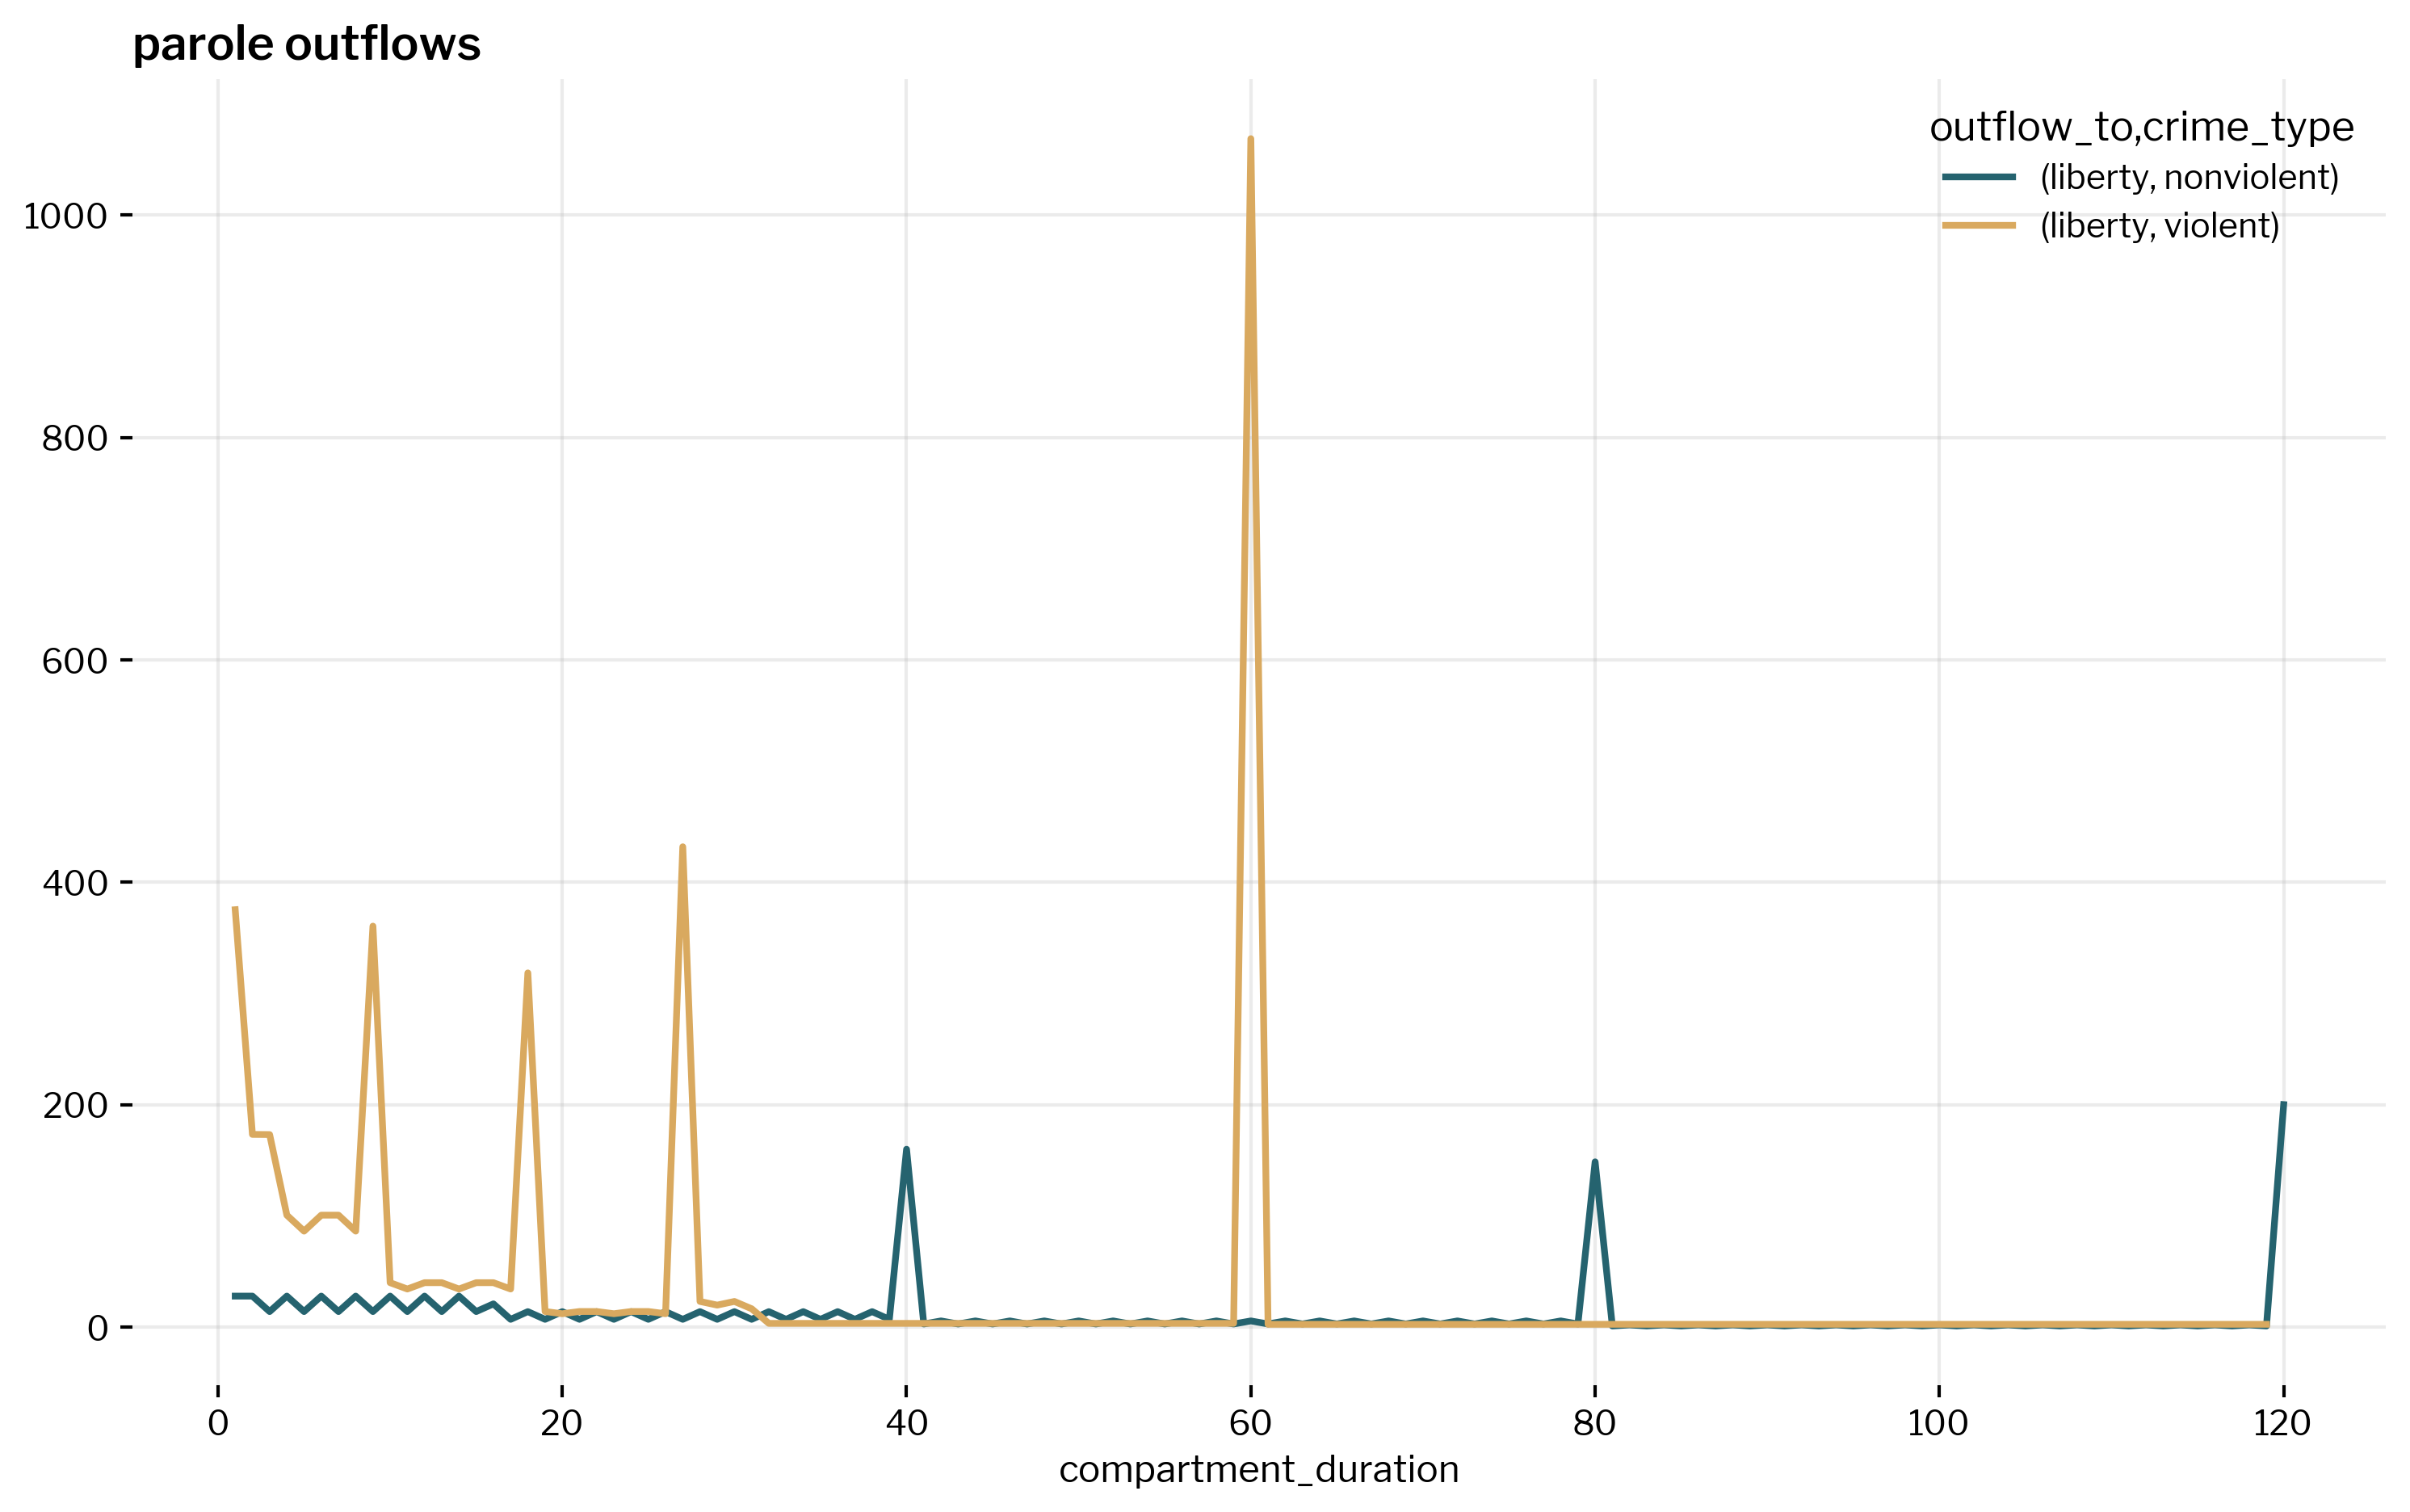

In [104]:
prisonrev_old[prisonrev_old.compartment == "parole"].groupby(
    ["outflow_to", "compartment_duration", "crime_type"]
)[["total_population"]].sum().reset_index().pivot(
    index="compartment_duration",
    columns=["outflow_to", "crime_type"],
    values="total_population",
).plot()
plt.title("parole outflows");

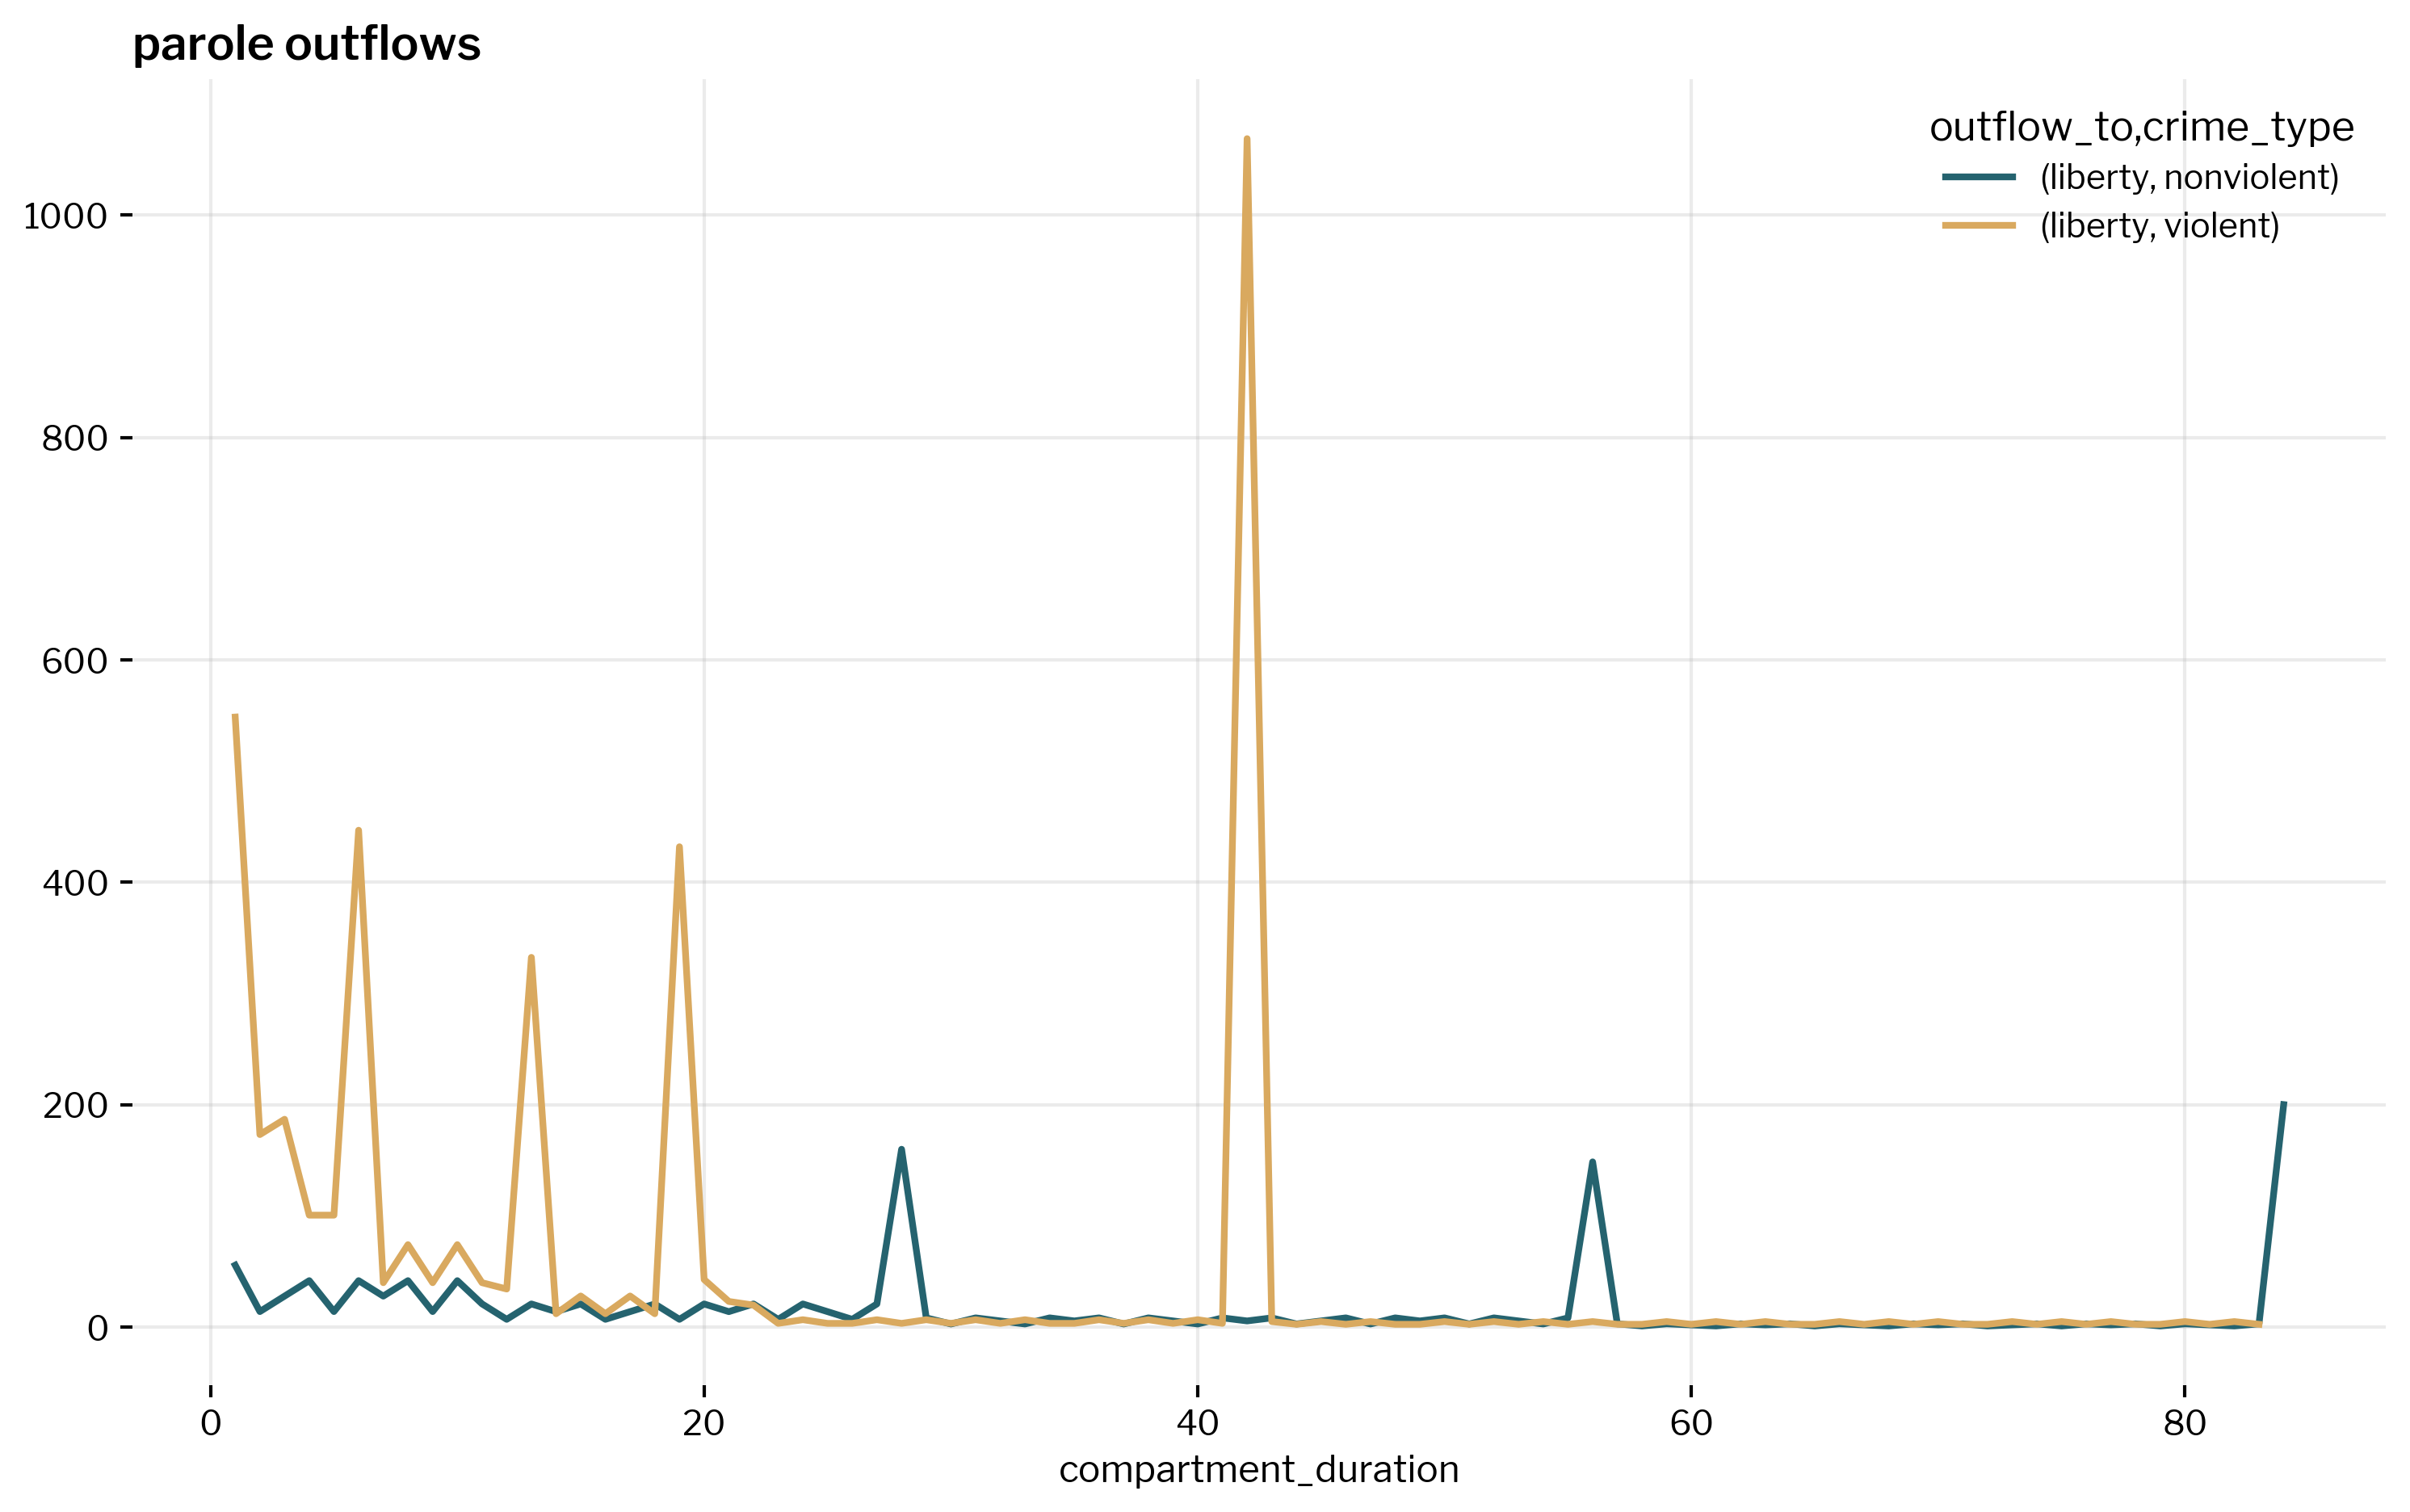

In [105]:
prisonrev.groupby(["outflow_to", "compartment_duration", "crime_type"])[
    ["total_population"]
].sum().reset_index().pivot(
    index="compartment_duration",
    columns=["outflow_to", "crime_type"],
    values="total_population",
).plot()
plt.title("parole outflows");

In [106]:
test_transitions[test_transitions.compartment == "prison"].groupby(
    ["outflow_to", "compartment_duration"]
)[["total_population"]].sum()

prisonrev.groupby(["grant_rate"]).apply(
    lambda x: np.average(x.compartment_duration, weights=x.total_population)
) / 12

grant_rate
0.5    1.962332
dtype: float64

In [107]:
prisonrev.compartment_duration.max()

84.0

In [108]:
prisonrev_old.groupby(["grant_rate"]).apply(
    lambda x: np.average(x.compartment_duration, weights=x.total_population)
) / 12

grant_rate
0.5    2.803096
dtype: float64

In [109]:
prisonrev_old.compartment_duration.max()

120.0

# visualize transitions

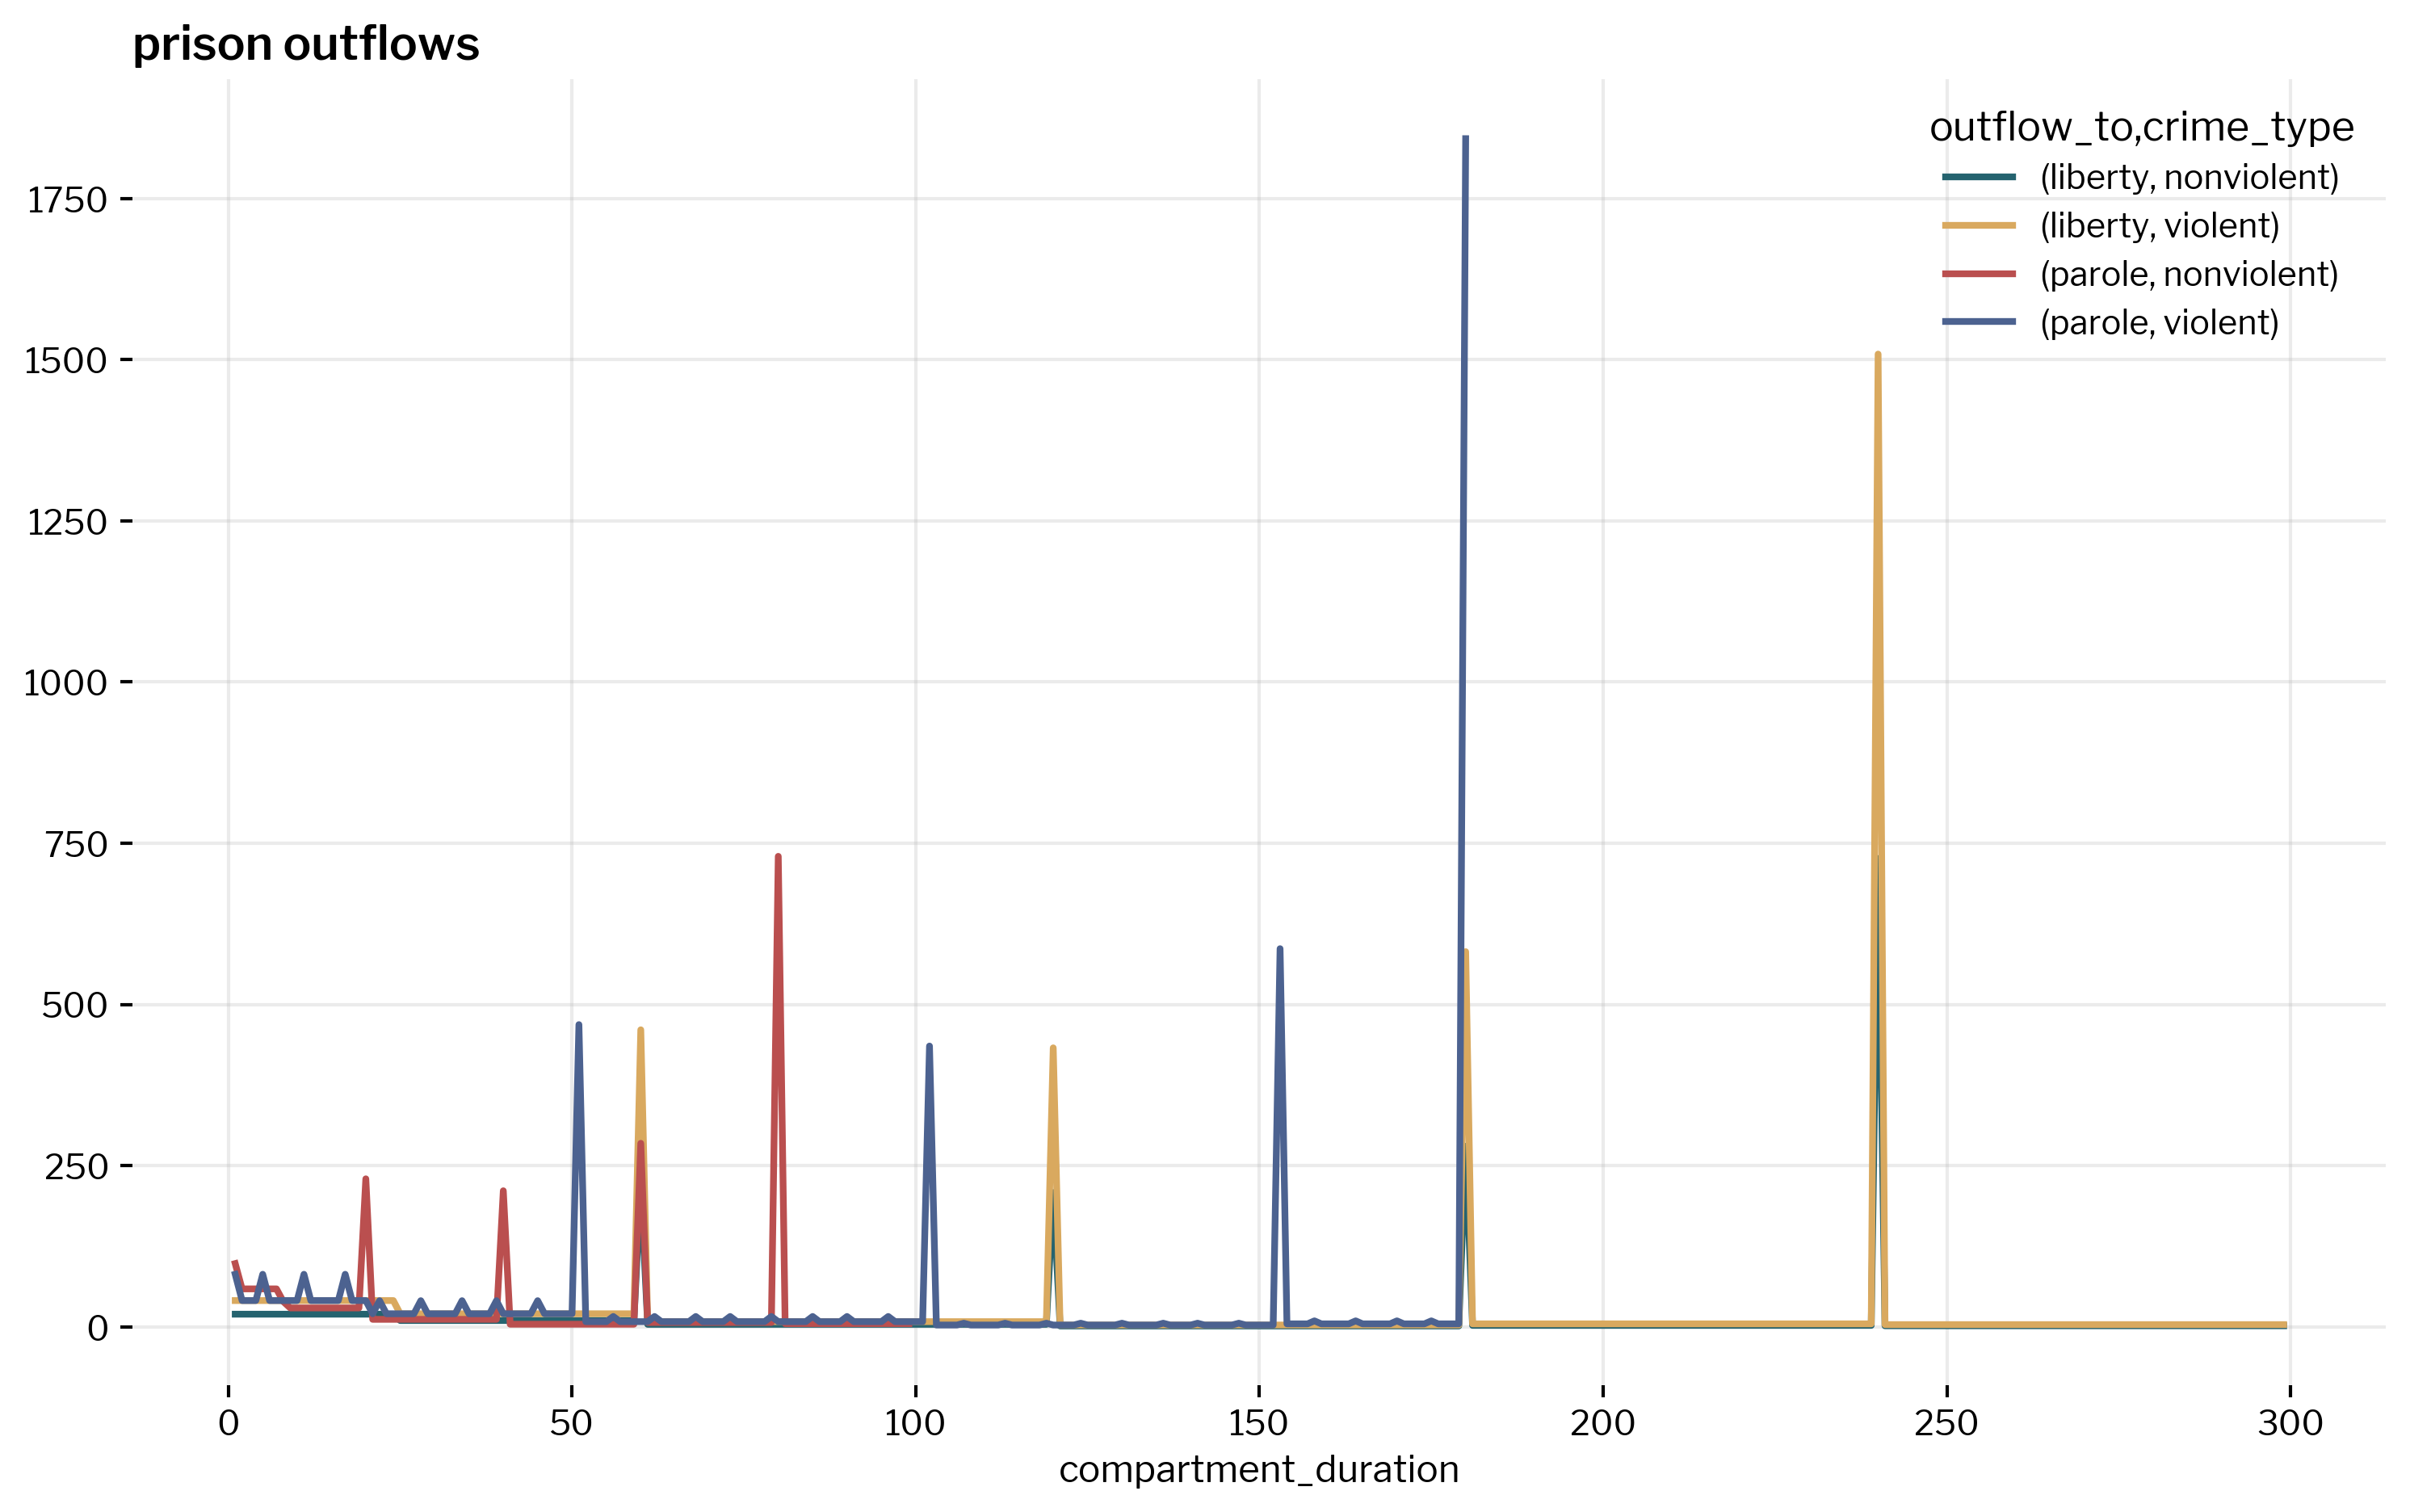

In [110]:
test_transitions[(test_transitions.compartment == "prison")].groupby(
    ["outflow_to", "crime_type", "compartment_duration"]
)[["total_population"]].sum().reset_index().pivot(
    index="compartment_duration",
    columns=[
        "outflow_to",
        "crime_type",
    ],
    values="total_population",
).plot()
plt.title("prison outflows");

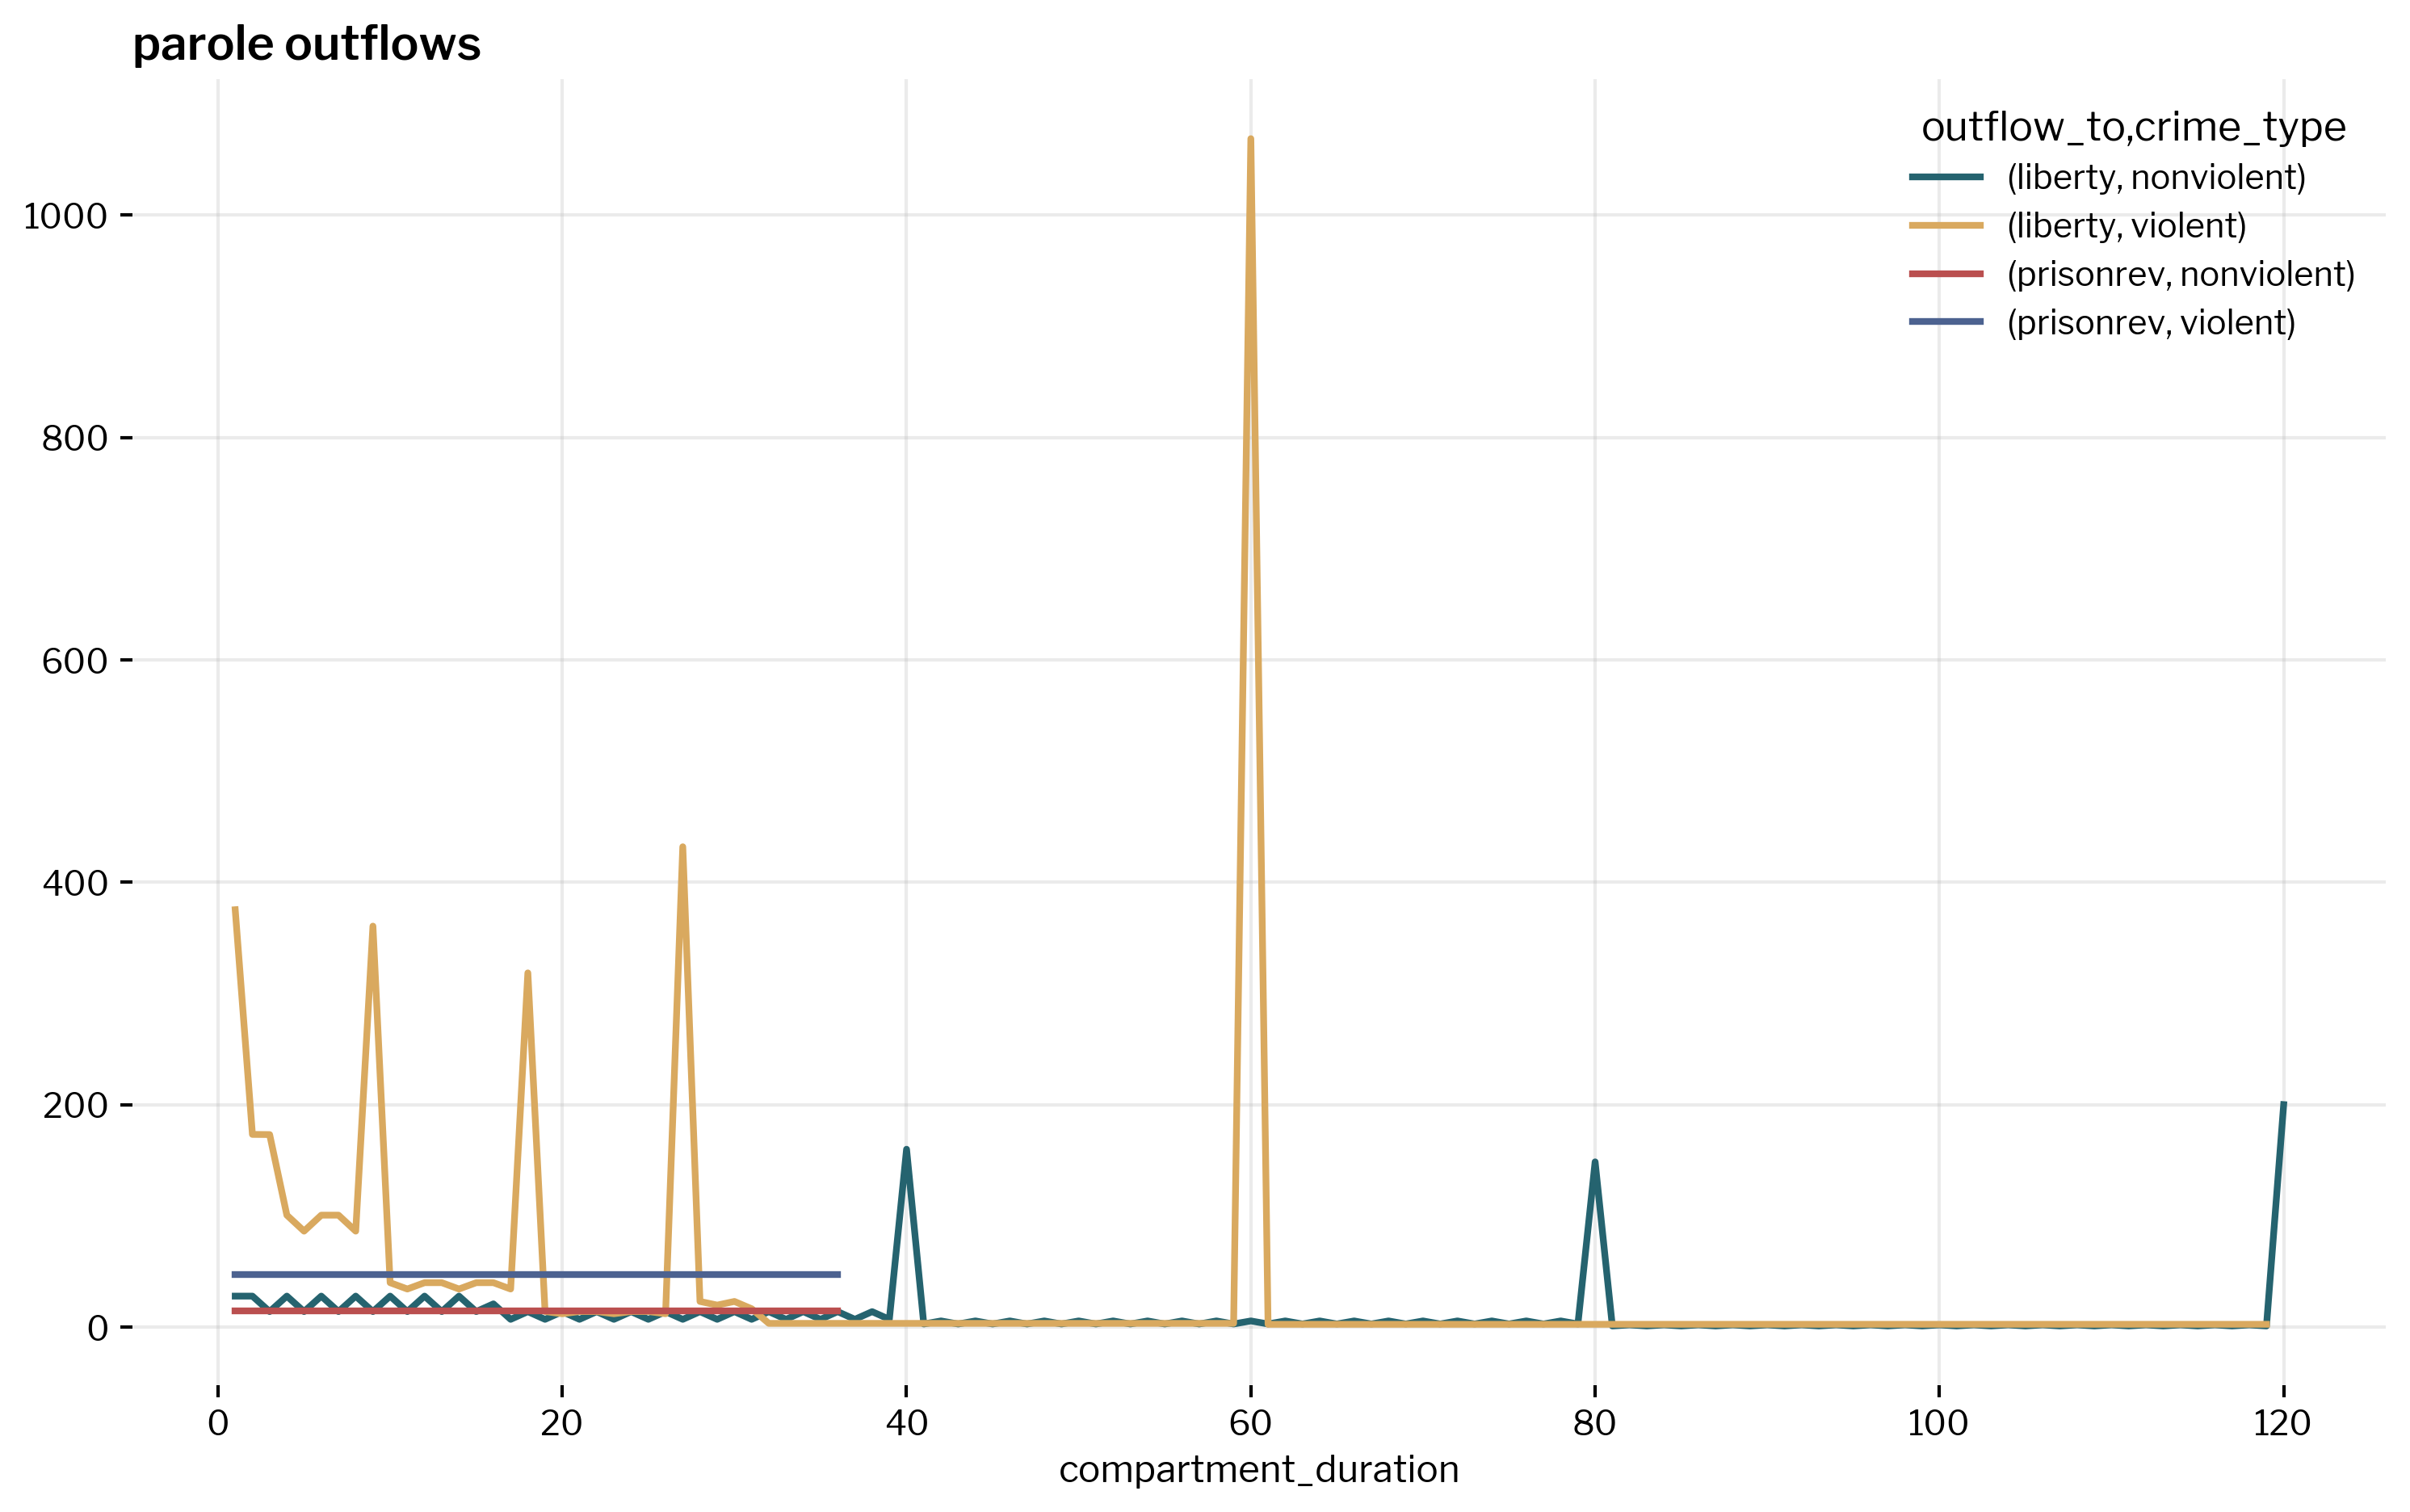

In [111]:
test_transitions[test_transitions.compartment == "parole"].groupby(
    ["outflow_to", "compartment_duration", "crime_type"]
)[["total_population"]].sum().reset_index().pivot(
    index="compartment_duration",
    columns=["outflow_to", "crime_type"],
    values="total_population",
).plot()
plt.title("parole outflows");

<Axes: xlabel='compartment_duration'>

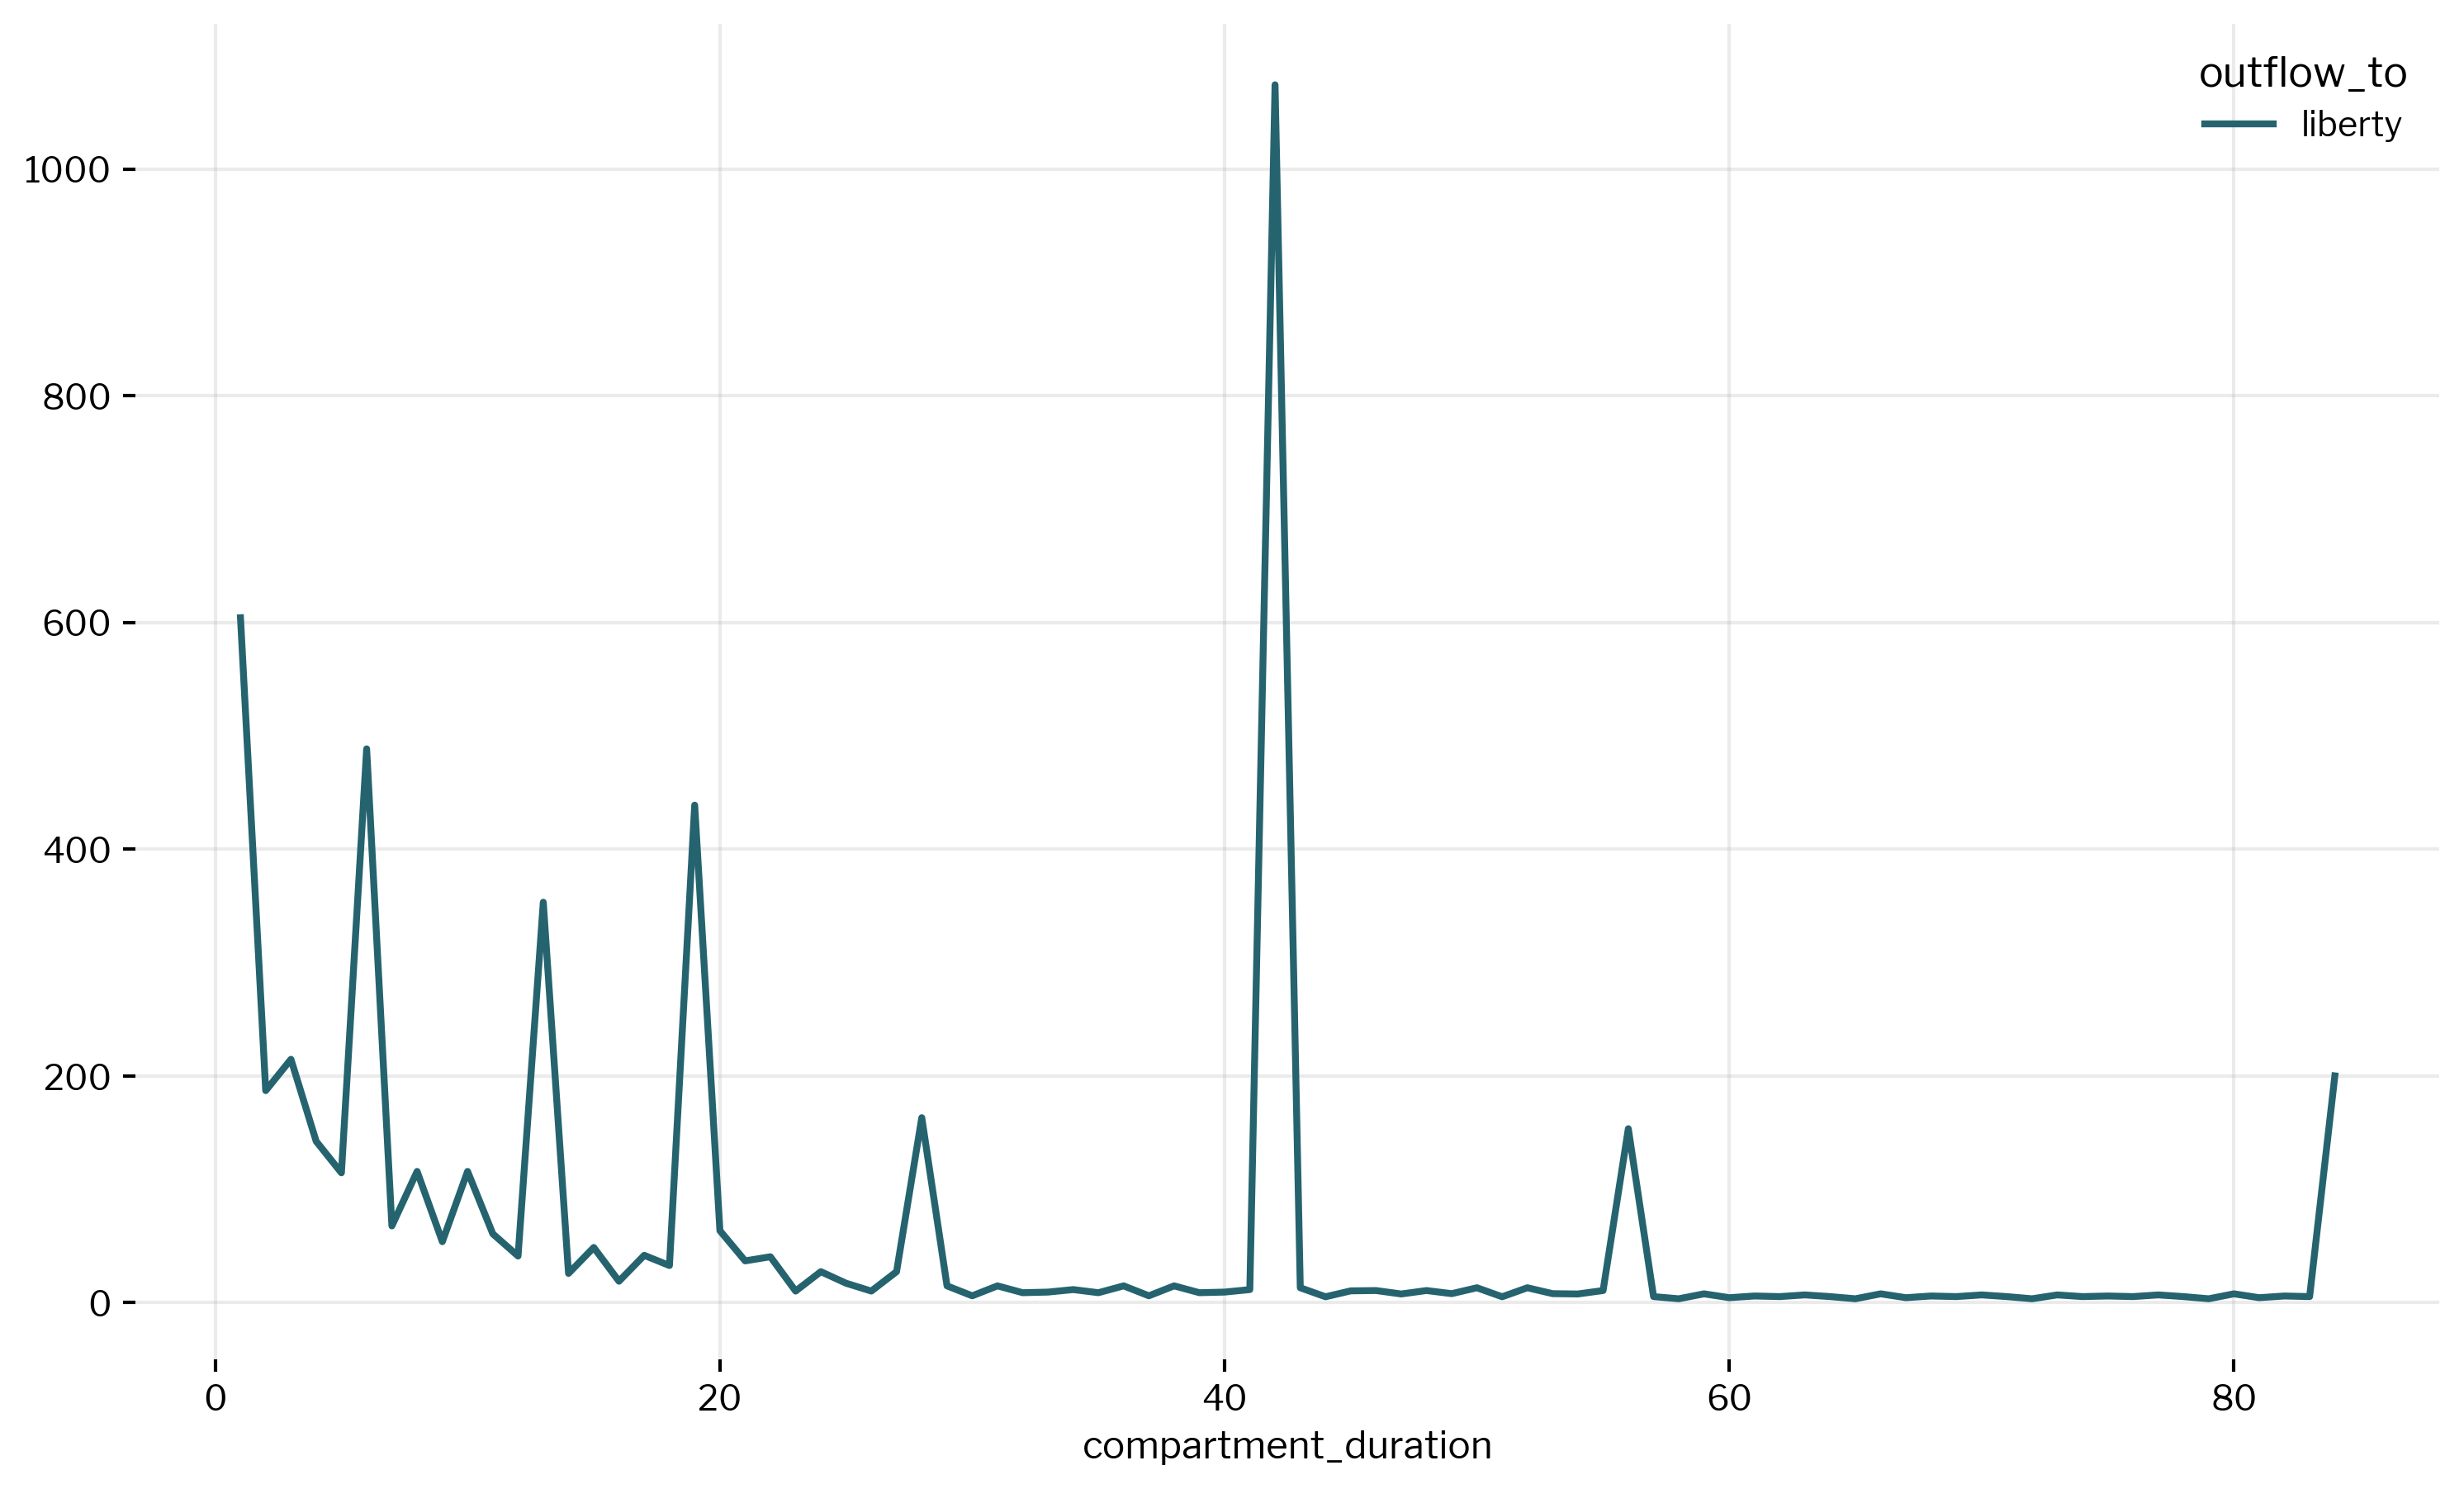

In [112]:
test_transitions[test_transitions.compartment == "prisonrev"].groupby(
    ["outflow_to", "compartment_duration"]
)[["total_population"]].sum().reset_index().pivot(
    index="compartment_duration", columns="outflow_to", values="total_population"
).plot()

### generate transitions

In [113]:
diff_grant_rate_transitions = []
for grant_rate in [
    0.1,
    #     0.3,
    0.5
    #     0.09,0.18,0.45,0.9
    #     0.09,.43,.77
]:
    display(f"GRANT RATE is {grant_rate}")
    transitions = get_transitions_with_grant_rate(los, grant_rate)

    display(
        transitions[transitions.compartment == "prison"]
        .sort_values(by=["compartment_duration", "crime_type"])
        .head(6)
    )
    diff_grant_rate_transitions.append(transitions)

'GRANT RATE is 0.1'

'parole release rate = 0.1'

crime_type
nonviolent     366.754237
violent       1158.097500
Name: total_population, dtype: float64

crime_type
nonviolent     366.754237
violent       1158.097500
Name: total_population, dtype: float64

,compartment_duration
crime_type,
nonviolent,120.0
violent,119.0


,total_population
crime_type,
nonviolent,259.808702
violent,820.396269


,compartment_duration
crime_type,
nonviolent,84.0
violent,83.0


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
0,0.1,prisonrev,liberty,nonviolent,1.0,11.120109
1,0.1,prisonrev,liberty,nonviolent,2.0,2.780027
2,0.1,prisonrev,liberty,nonviolent,3.0,5.560054
3,0.1,prisonrev,liberty,nonviolent,4.0,8.340082
4,0.1,prisonrev,liberty,nonviolent,5.0,2.780027


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
162,0.1,prisonrev,liberty,violent,79.0,0.490327
163,0.1,prisonrev,liberty,violent,80.0,0.980654
164,0.1,prisonrev,liberty,violent,81.0,0.490327
165,0.1,prisonrev,liberty,violent,82.0,0.980654
166,0.1,prisonrev,liberty,violent,83.0,0.490327


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
1,0.1,prison,liberty,nonviolent,1.0,35.319375
4,0.1,prison,parole,nonviolent,1.0,19.621875
2,0.1,prison,liberty,violent,1.0,73.355625
3,0.1,prison,parole,violent,1.0,16.301250
9,0.1,prison,parole,nonviolent,2.0,11.773125
10,0.1,prison,liberty,nonviolent,2.0,35.319375


'GRANT RATE is 0.5'

'parole release rate = 0.5'

crime_type
nonviolent    1833.771186
violent       5790.487500
Name: total_population, dtype: float64

crime_type
nonviolent    1833.771186
violent       5790.487500
Name: total_population, dtype: float64

,compartment_duration
crime_type,
nonviolent,120.0
violent,119.0


,total_population
crime_type,
nonviolent,1299.043508
violent,4101.981345


,compartment_duration
crime_type,
nonviolent,84.0
violent,83.0


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
0,0.5,prisonrev,liberty,nonviolent,1.0,55.600545
1,0.5,prisonrev,liberty,nonviolent,2.0,13.900136
2,0.5,prisonrev,liberty,nonviolent,3.0,27.800272
3,0.5,prisonrev,liberty,nonviolent,4.0,41.700409
4,0.5,prisonrev,liberty,nonviolent,5.0,13.900136


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
162,0.5,prisonrev,liberty,violent,79.0,2.451634
163,0.5,prisonrev,liberty,violent,80.0,4.903269
164,0.5,prisonrev,liberty,violent,81.0,2.451634
165,0.5,prisonrev,liberty,violent,82.0,4.903269
166,0.5,prisonrev,liberty,violent,83.0,2.451634


,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
1,0.5,prison,liberty,nonviolent,1.0,19.621875
4,0.5,prison,parole,nonviolent,1.0,98.109375
2,0.5,prison,liberty,violent,1.0,40.753125
3,0.5,prison,parole,violent,1.0,81.506250
9,0.5,prison,parole,nonviolent,2.0,58.865625
10,0.5,prison,liberty,nonviolent,2.0,19.621875


In [114]:
def plot_cdf(transitions_list):
    for comp in transitions_list[0].compartment.unique():
        if comp == "liberty":
            continue
        comp_transitions_list = [x[x.compartment == comp] for x in transitions_list]
        cdfs = [
            y.groupby("compartment_duration")[["total_population"]].sum().cumsum()
            / y.total_population.sum()
            for y in comp_transitions_list
        ]
        cdfs = [
            cdf.rename(columns={"total_population": f"{comp}_{i}"})
            for i, cdf in enumerate(cdfs)
        ]
        pd.concat(cdfs, axis=1).plot()
        plt.title(comp);

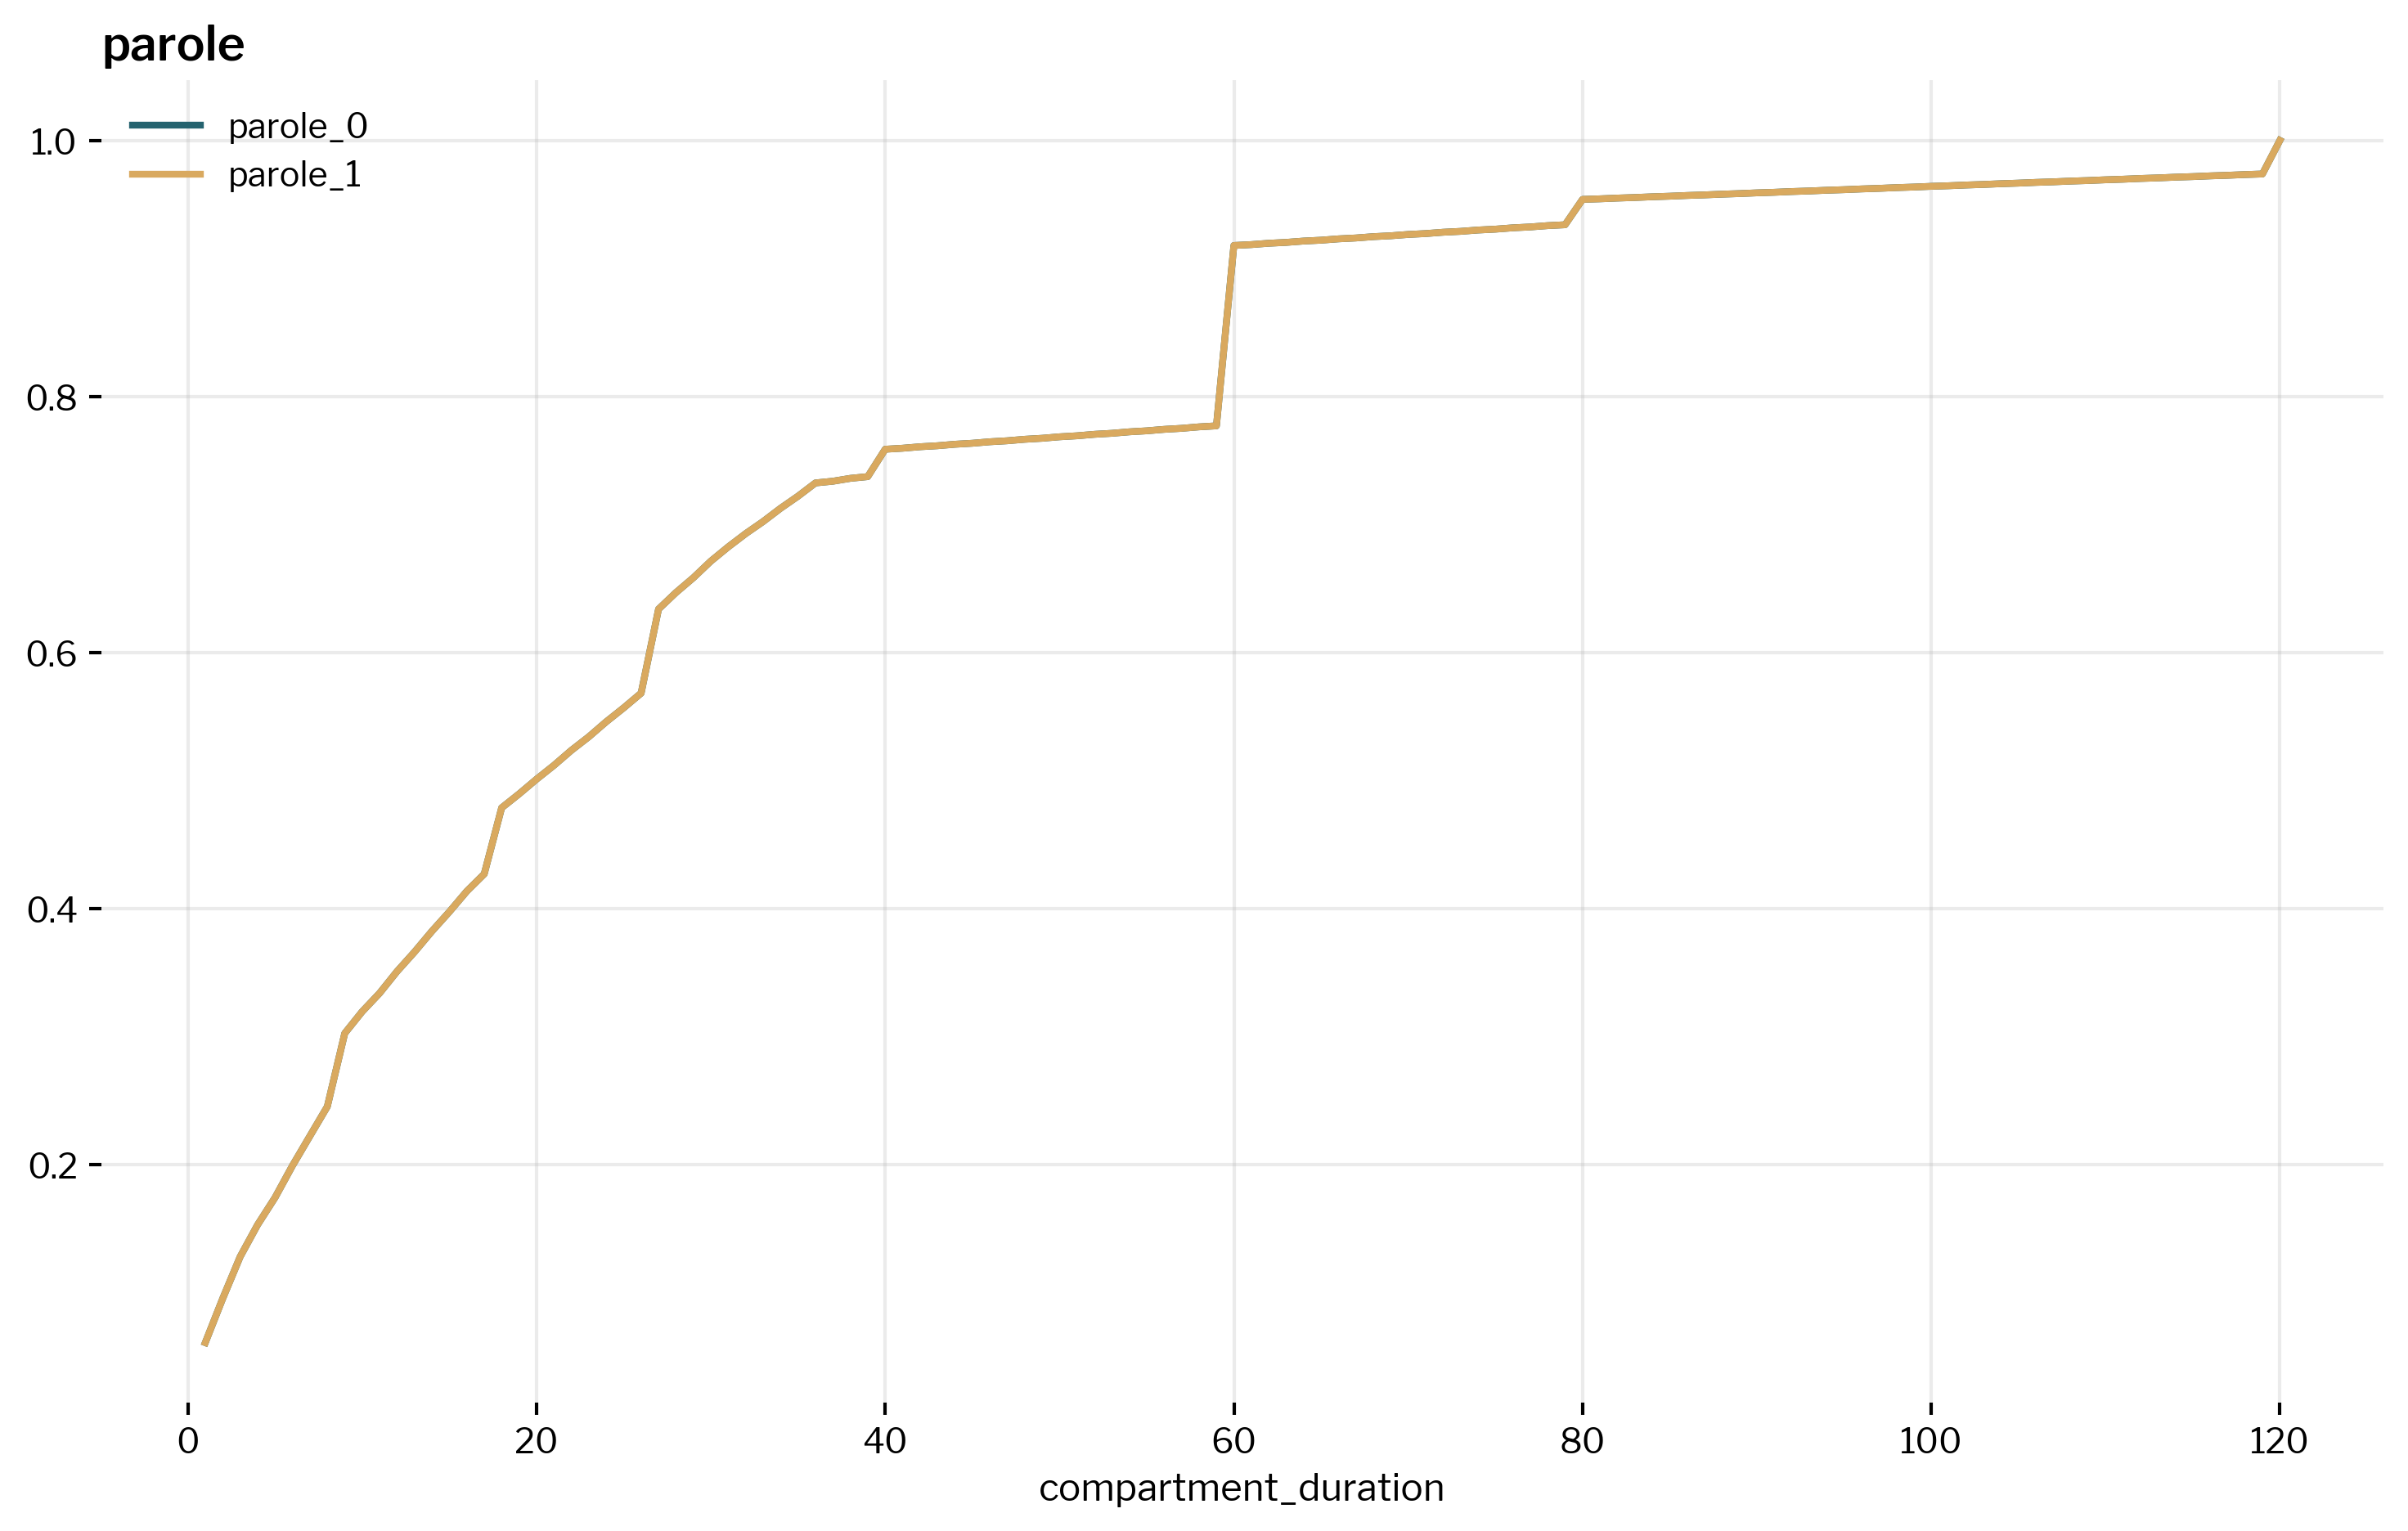

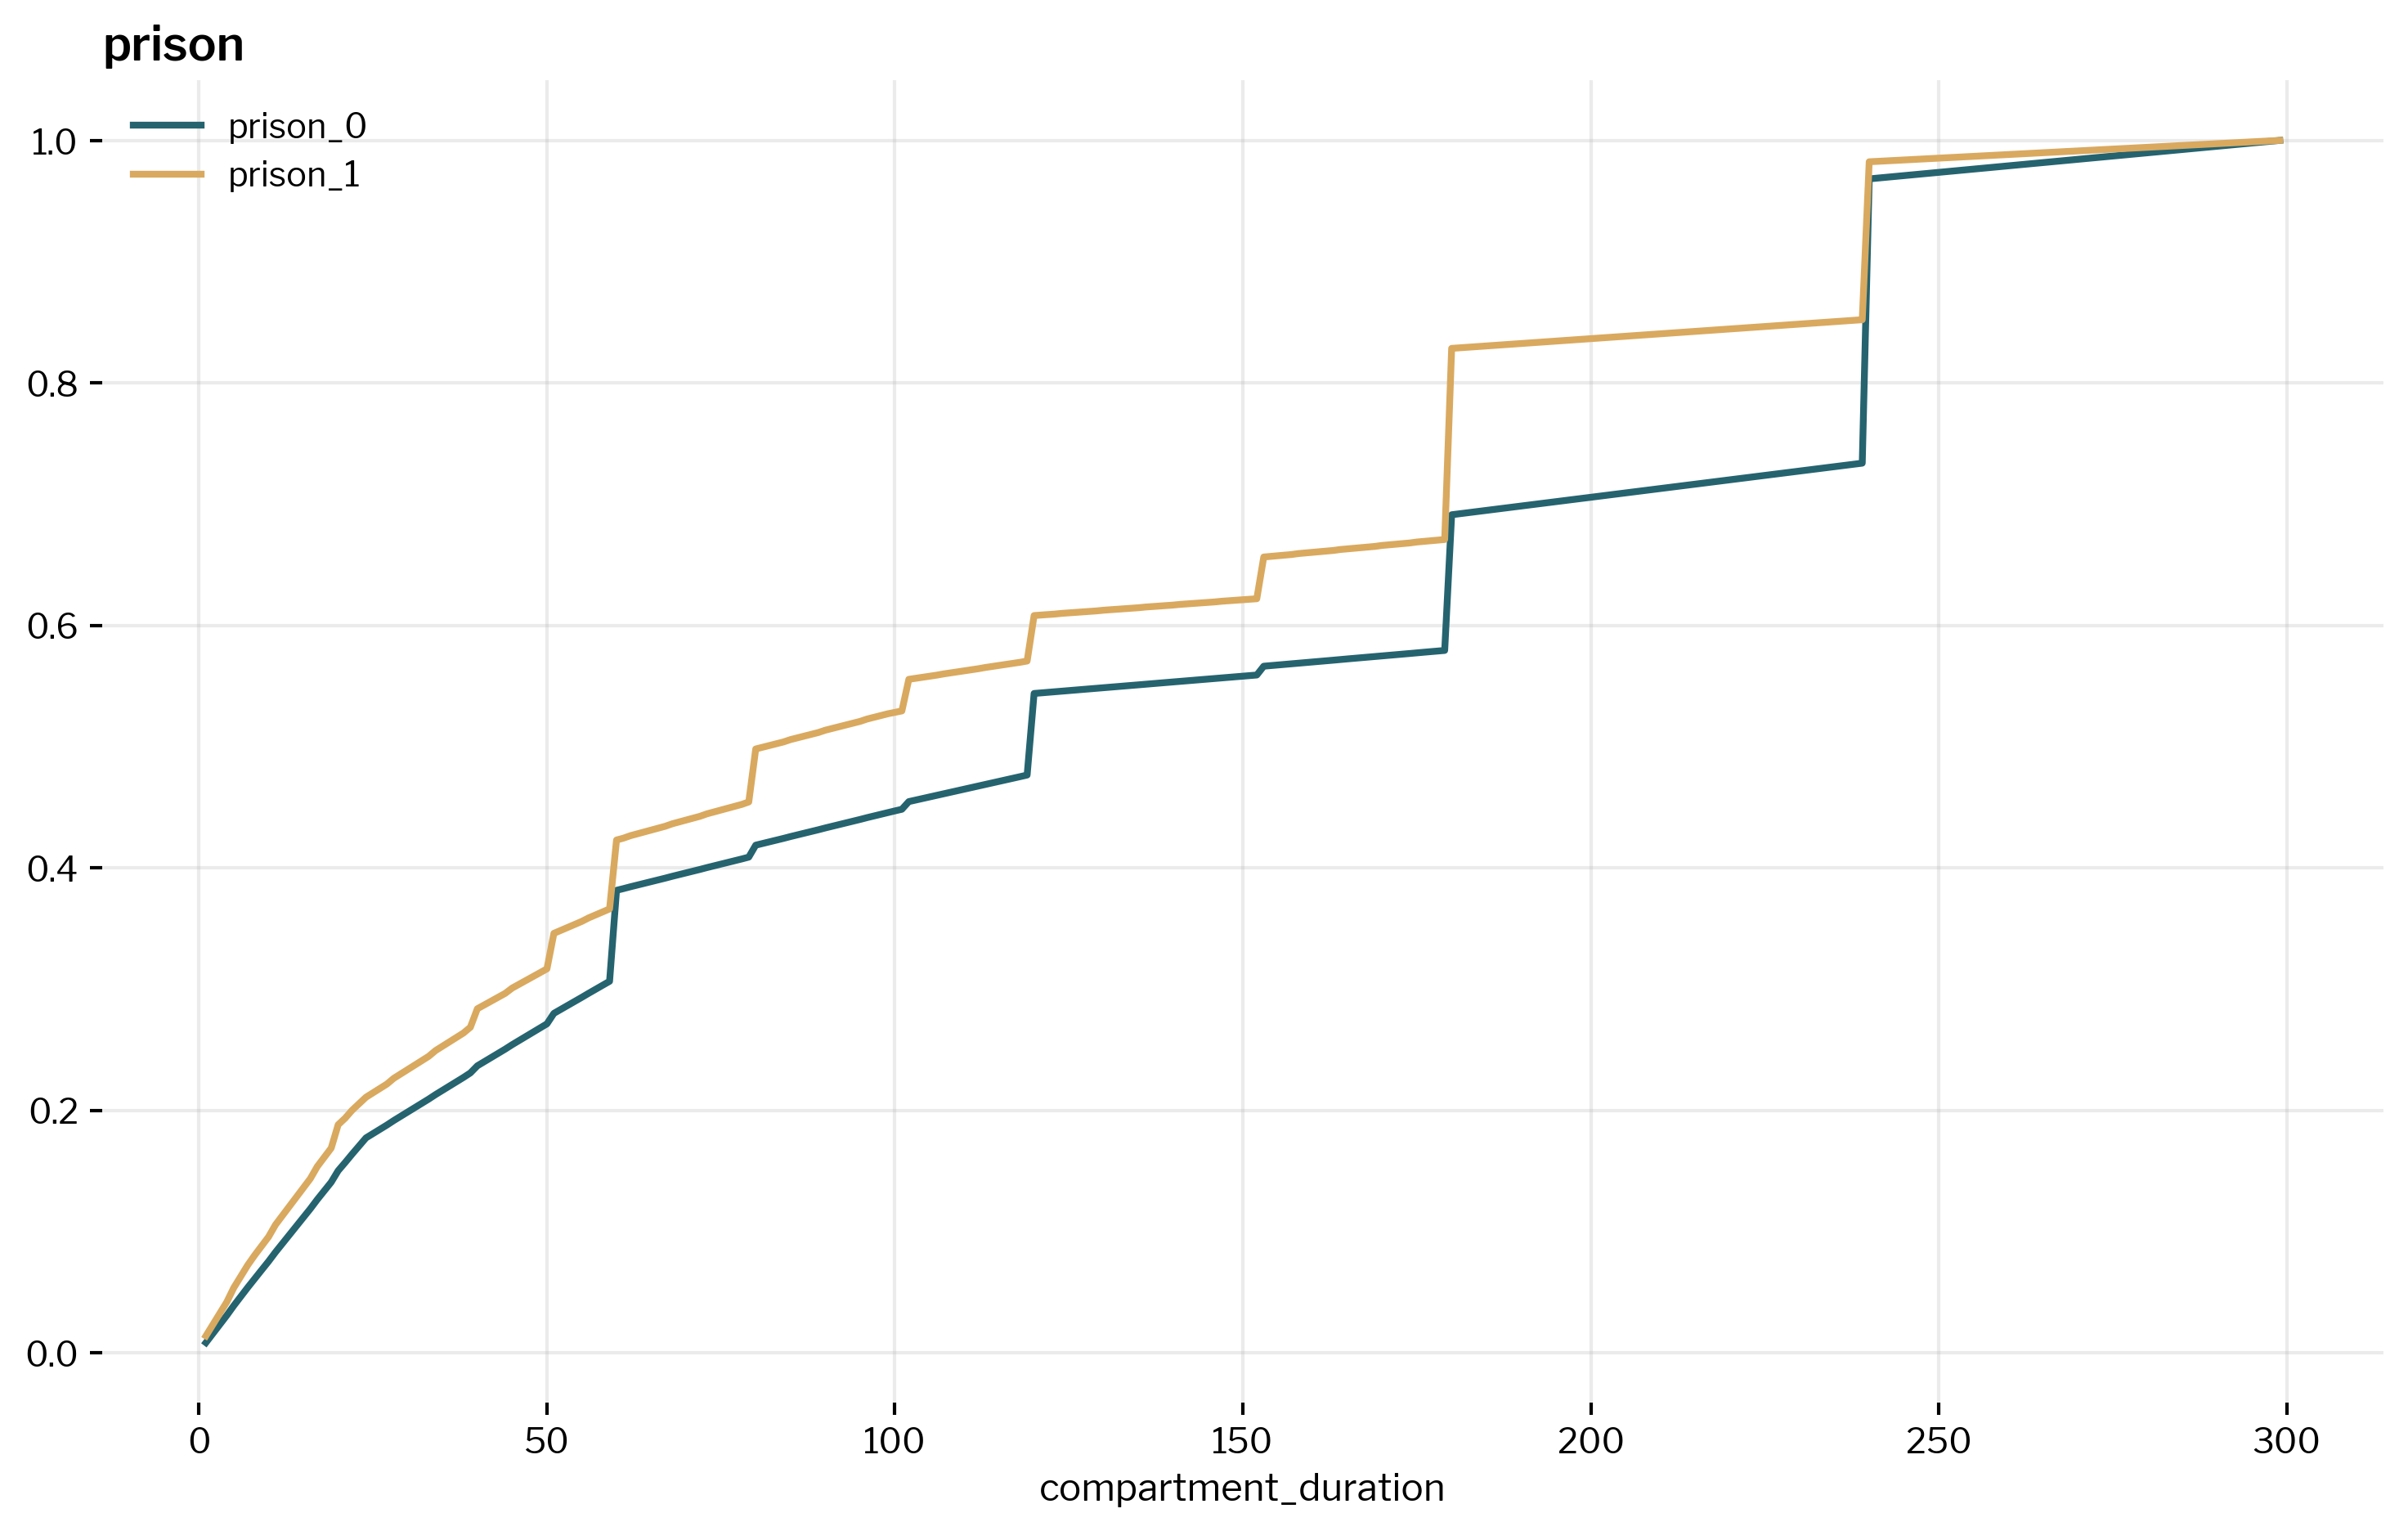

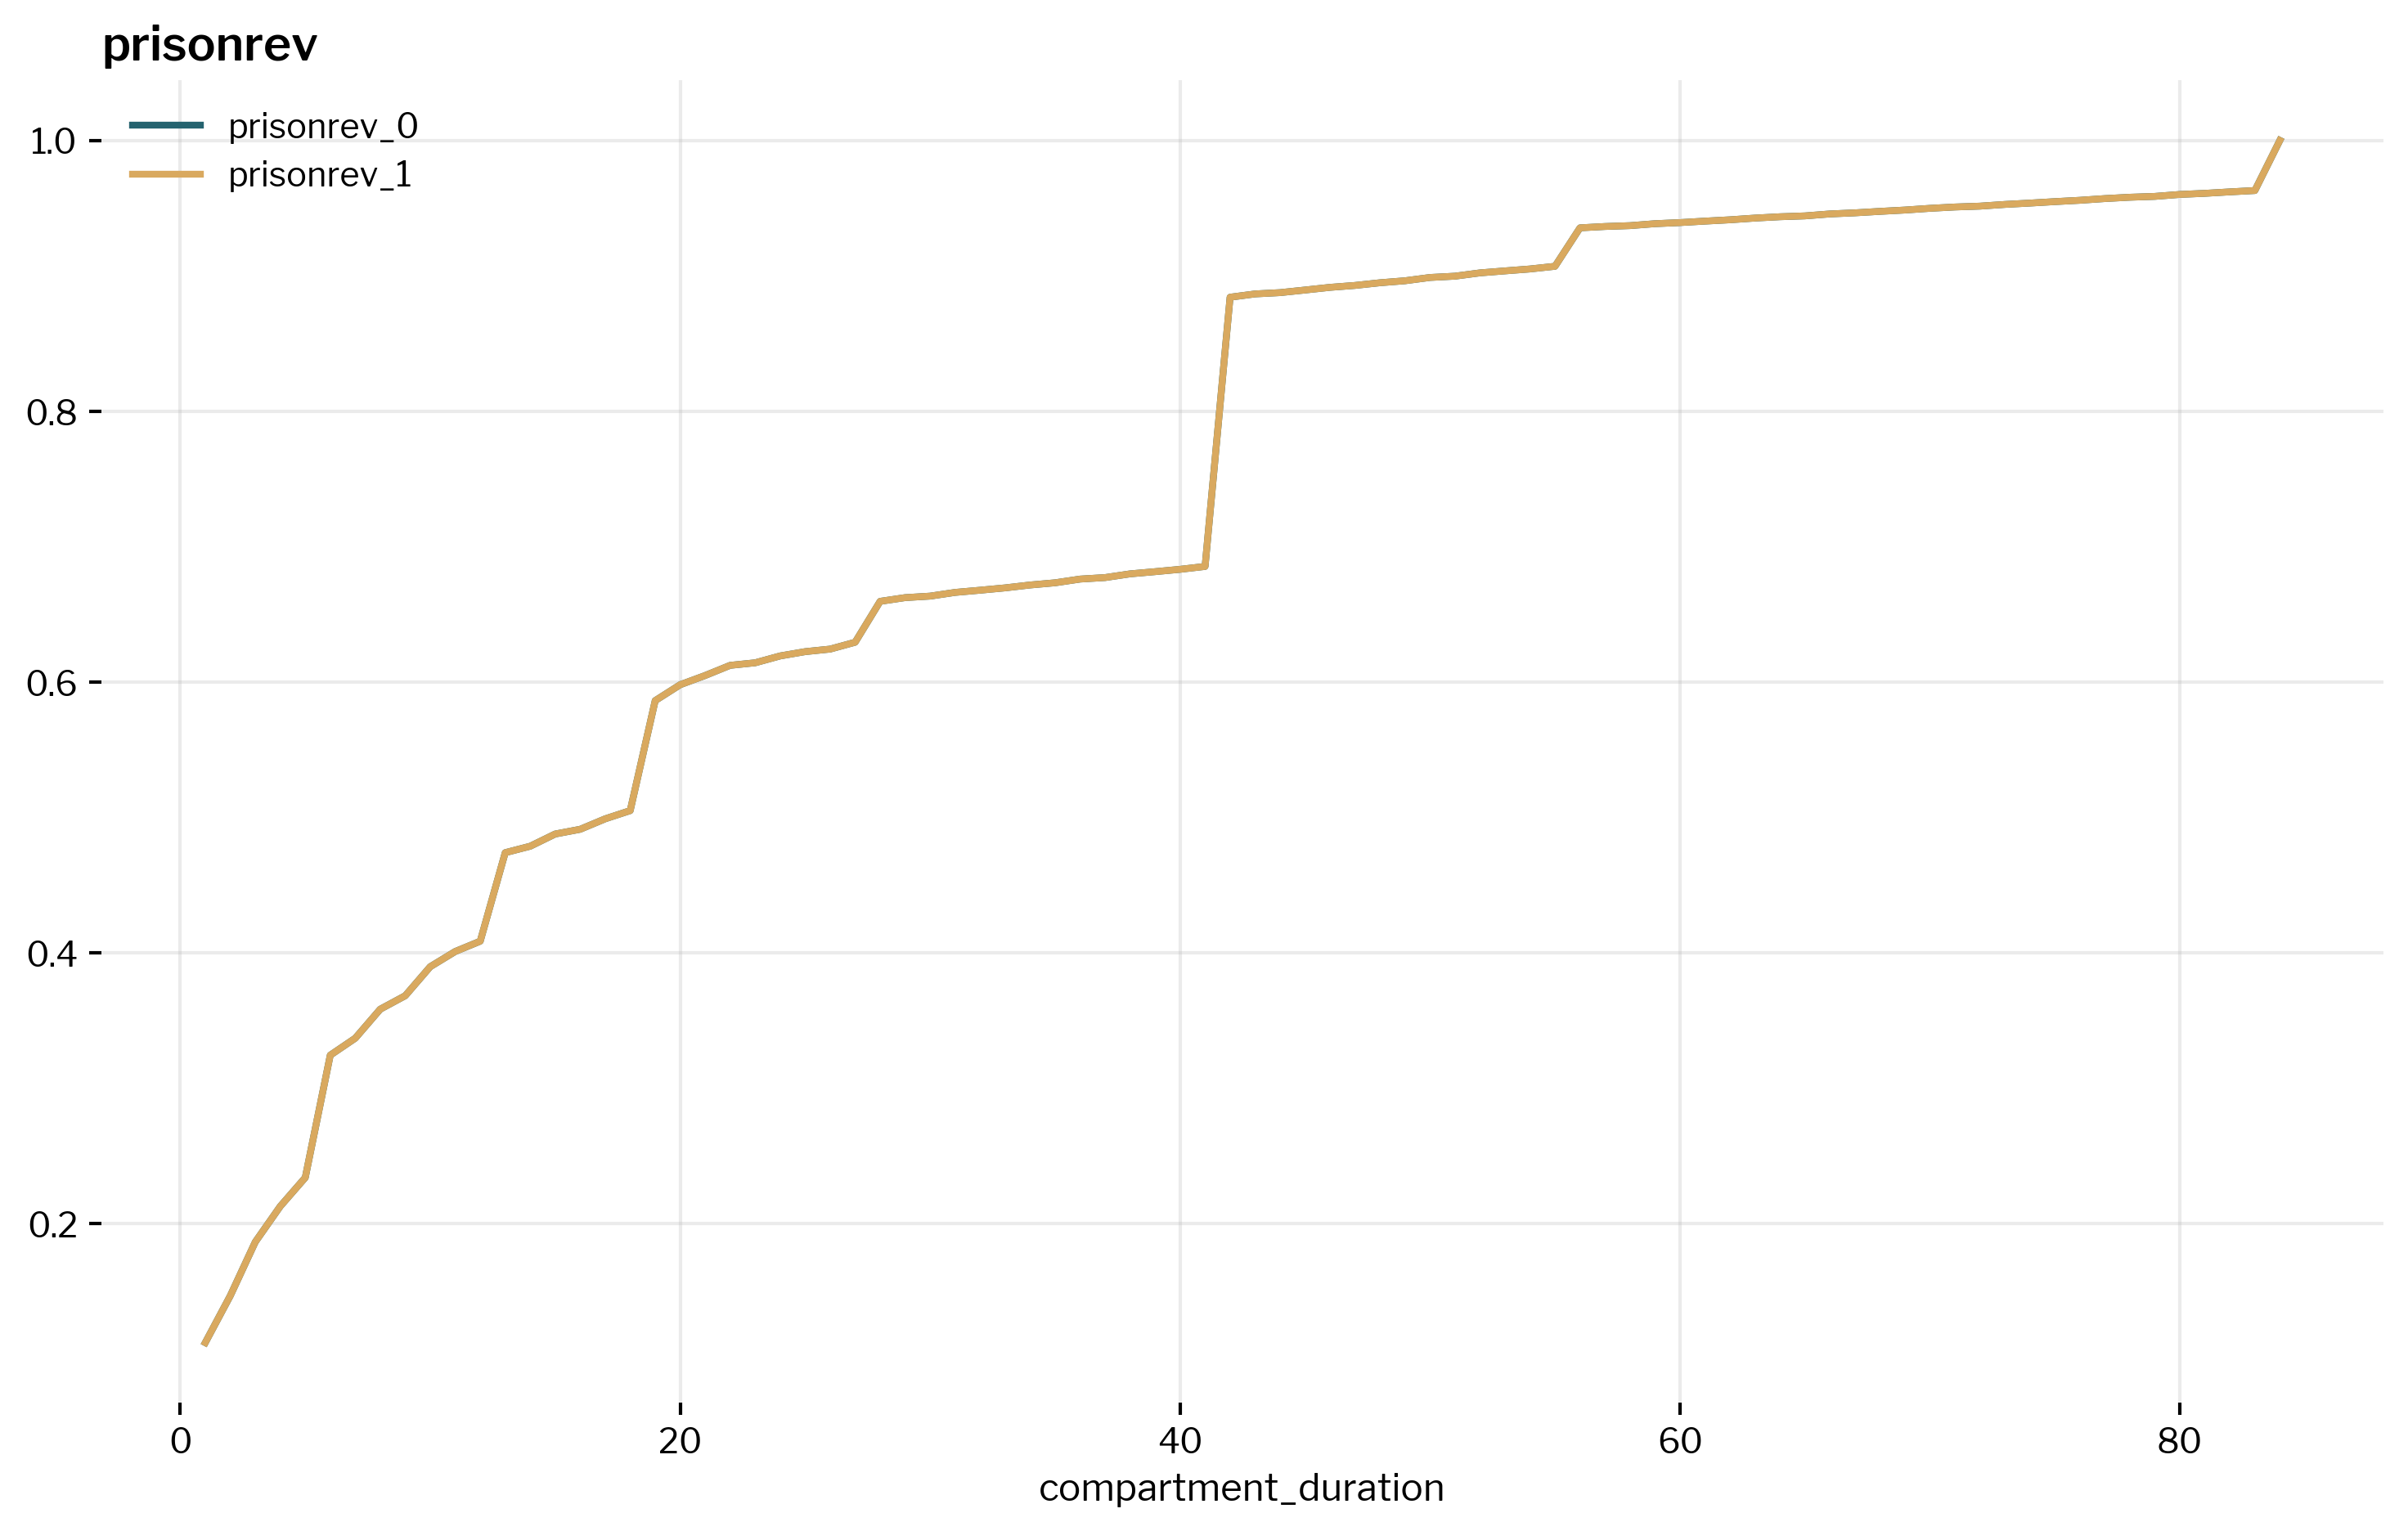

In [115]:
plot_cdf(diff_grant_rate_transitions)

In [116]:
[len(x) for x in diff_grant_rate_transitions]

[1357, 1357]

In [117]:
transitions = pd.concat(diff_grant_rate_transitions)

In [118]:
transitions.shape

(2714, 6)

In [119]:
def wm(group):
    return sum(group.compartment_duration * group.total_population) / sum(
        group.total_population
    )

In [120]:
(
    transitions.groupby(
        ["grant_rate", "compartment", "outflow_to", "crime_type"]
    ).apply(wm)
    / 12
).to_frame()

0
grant_rate compartment outflow_to crime_type           
0.1        liberty     liberty    nonviolent   0.083333
                                  violent      0.083333
           parole      liberty    nonviolent   4.283817
                                  violent      2.334171
                       prisonrev  nonviolent   1.541667
                                  violent      1.541667
           prison      liberty    nonviolent  11.061826
                                  violent     11.061826
                       parole     nonviolent   3.674796
                                  violent      8.697435
           prisonrev   liberty    nonviolent   2.998523
                                  violent      1.634184
0.5        liberty     liberty    nonviolent   0.083333
                                  violent      0.083333
           parole      liberty    nonviolent   4.283817
                                  violent      2.334171
                       prisonrev  nonviolent   1.541667
                                  violent      1.541667
           prison      liberty    nonviolent  11.061826
                                  violent     11.061826
                       parole     nonviolent   3.674796
                                  violent      8.697435
           prisonrev   liberty    nonviolent   2.998523
                                  violent      1.634184

In [121]:
transitions.groupby(["grant_rate"]).apply(
    lambda x: np.average(x.compartment_duration, weights=x.total_population)
)

grant_rate
0.1    114.610376
0.5     73.416015
dtype: float64

In [122]:
x = transitions.groupby(["grant_rate", "compartment", "outflow_to"])[
    ["total_population"]
].sum()
x["total"] = x.groupby(["grant_rate", "compartment"]).total_population.transform(sum)
x["ratio"] = x.total_population / x.total
x

total_population         total   ratio
grant_rate compartment outflow_to                                        
0.1        liberty     liberty             2.000000      2.000000  1.0000
           parole      liberty          1080.204971   1524.851737  0.7084
                       prisonrev         444.646767   1524.851737  0.2916
           prison      liberty         15441.300000  17157.000000  0.9000
                       parole           1715.700000  17157.000000  0.1000
           prisonrev   liberty          1080.204971   1080.204971  1.0000
0.5        liberty     liberty             2.000000      2.000000  1.0000
           parole      liberty          5401.024853   7624.258686  0.7084
                       prisonrev        2223.233833   7624.258686  0.2916
           prison      liberty          8578.500000  17157.000000  0.5000
                       parole           8578.500000  17157.000000  0.5000
           prisonrev   liberty          5401.024853   5401.024853  1.0000

# upload setup

In [123]:
simulation_tag

'al_parole_grant_rate_v1'

In [124]:
total_population_upload = total_population.reset_index()
total_population_upload.loc[:, "time_step"] = convert_dates(
    time_converter, total_population_upload.Month
)
total_population_upload.drop(columns="Month", inplace=True)

In [125]:
outflows_upload = outflows.copy()
outflows_upload.loc[:, "time_step"] = convert_dates(
    time_converter, outflows_upload.Month
)
outflows_upload.drop(columns="Month", inplace=True)

In [126]:
transitions_upload = transitions[
    transitions.grant_rate == min(transitions.grant_rate)
].drop(columns="grant_rate")

In [127]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows_upload,
    transitions_data_df=transitions_upload,
    total_population_data_df=total_population_upload,
    yaml_path=yaml_file_path,
)

100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


In [128]:
alt_transitions = transitions[transitions.grant_rate != min(transitions.grant_rate)]
alt_transitions.to_csv("alternate_grant_rate_transitions.csv", index=False)
alt_transitions.sort_values(
    by=["compartment", "compartment_duration"], ascending=[False, True]
).head()

,grant_rate,compartment,outflow_to,crime_type,compartment_duration,total_population
0,0.5,prisonrev,liberty,nonviolent,1.0,55.600545
84,0.5,prisonrev,liberty,violent,1.0,548.520761
1,0.5,prisonrev,liberty,nonviolent,2.0,13.900136
85,0.5,prisonrev,liberty,violent,2.0,173.092417
2,0.5,prisonrev,liberty,nonviolent,3.0,27.800272


In [168]:
outflows_upload.head()

,total_population,compartment,outflow_to,crime_type,time_step
0,135.000,pretrial,prison,violent,-72
1,65.000,pretrial,prison,nonviolent,-72
2,126.225,pretrial,prison,violent,-71
3,60.775,pretrial,prison,nonviolent,-71
4,143.775,pretrial,prison,violent,-70


In [169]:
transitions_upload.head()

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,parole,liberty,nonviolent,1.0,5.560054
1,prison,liberty,nonviolent,1.0,35.319375
2,prison,liberty,violent,1.0,73.355625
3,prison,parole,violent,1.0,16.301250
4,prison,parole,nonviolent,1.0,19.621875


# calibration

In [129]:
df.head()

NameError: name 'df' is not defined

In [ ]:
# wm = lambda x: np.average(x, weights=df.loc[x.index, "total_population"])
# df = transitions.copy()#.set_index("compartment_duration")
df.groupby(["grant_rate", "compartment", "outflow_to", "crime_type"]).agg(
    adjusted_lots=("total_population", "sum"),
    price_weighted_mean=("compartment_duration", wm),
)

In [ ]:
def wm(group):
    return sum(group.compartment_duration * group.total_population) / sum(
        group.total_population
    )

In [ ]:
(
    transitions.groupby(
        ["grant_rate", "compartment", "outflow_to", "crime_type"]
    ).apply(wm)
    / 12
).to_frame()

In [ ]:
time = (
    (
        df.groupby(["grant_rate", "compartment", "outflow_to", "crime_type"]).apply(wm)
        / 12
    )
    .to_frame()
    .reset_index()
)
time

In [ ]:
time[(time.compartment == "prison") & (time.outflow_to == "liberty")]

In [ ]:
time[(time.compartment == "prison") & (time.outflow_to == "parole")]

In [ ]:
for g, gs in time.groupby("grant_rate"):
    display(gs.loc[("parole", "libery", "violent"), :])

In [ ]:
for g, group in df.groupby(["grant_rate", "compartment", "outflow_to", "crime_type"]):
    display(group)
    display(
        sum(group.compartment_duration * group.total_population)
        / sum(group.total_population)
    )

### parole releases

In [ ]:
outflows_with_type.sample(15)

In [ ]:
monthly_parole_readm = outflows_with_type[
    outflows_with_type.admission_type == "parole_readmission"
]
monthly_parole_readm = monthly_parole_readm.set_index("Month").rename(
    columns={"total_population": "doc_parole_readm"}
)[["doc_parole_readm"]]

monthly_prison_to_liberty = outflows_with_type[
    outflows_with_type.admission_type == "release_to_liberty"
]
monthly_prison_to_liberty = monthly_prison_to_liberty.set_index("Month").rename(
    columns={"total_population": "release_to_liberty"}
)[["release_to_liberty"]]

In [ ]:
monthly_parole_rel = outflows_with_type[
    outflows_with_type.admission_type == "parole_release"
]
monthly_parole_rel = monthly_parole_rel.set_index("Month").rename(
    columns={"total_population": "doc_parole_release"}
)[["doc_parole_release"]]

In [ ]:
parole_release_calc = parole_pop.groupby("Month")[["total_population"]].sum()
parole_release_calc[
    "delta"
] = parole_release_calc.total_population - parole_release_calc.total_population.shift(1)
parole_release_calc = (
    parole_release_calc.merge(monthly_parole_rel, how="left", on="Month")
    .merge(monthly_parole_readm, how="left", on="Month")
    .merge(parole_rev, how="left", on="Month")
    .merge(monthly_prison_to_liberty, how="left", on="Month")
)
parole_release_calc["rev_avg"] = (
    parole_release_calc.revocations + parole_release_calc.doc_parole_readm
) / 2
parole_release_calc["rev_percent"] = (
    parole_release_calc.doc_parole_readm - parole_release_calc.revocations
) / parole_release_calc.revocations
# parole_release_calc['rev_diff'] = parole_release_calc.revocations - parole_release_calc.doc_parole_readm

parole_release_calc["releases_from_parole"] = (
    parole_release_calc.doc_parole_release
    - parole_release_calc.rev_avg
    - parole_release_calc.delta
)


# parole_release_calc['averaged_releases_from_parole'] = (
#     parole_release_calc.avg_releases_from_parole.mean()
# )
# parole_release_calc['averaged_releases_to_parole'] = (
#     parole_release_calc.doc_parole_release.mean()
# )
# parole_release_calc['averaged_releases_to_parole'] = (
#     parole_release_calc.doc_parole_release.mean()
# )

parole_release_calc

In [ ]:
parole_release_calc.mean()

In [ ]:
parole_release_calc[
    [
        "rev_percent",
        "doc_parole_release",
        "rev_avg",
        "releases_from_parole",
        "release_to_liberty",
        "delta",
    ]
].mean()

In [ ]:
parole_release_calc[
    [
        "averaged_releases_from_parole",
        "avg_releases_from_parole",
        "doc_parole_release",
        "averaged_releases_to_parole",
    ]
].plot()

In [ ]:
total_population[total_population.compartment == "parole"].tail()

In [ ]:
total_population.index

In [ ]:
total_population[total_population.compartment == "prison"].reset_index().groupby(
    ["Month", "compartment"]
).total_population.sum().plot(rot=270)

In [ ]:
total_population[total_population.compartment == "parole"].reset_index().groupby(
    ["Month", "compartment"]
).total_population.sum().plot(rot=270)

# OLD

#### CONVERSION RATES

In [ ]:
# rev = pd.merge(
#     parole_rev,
#     outflows_with_type[outflows_with_type.admission_type == "parole_release"],
#     on="Month",
# )
# rev["prop"] = (rev.revocations - rev.total_population) / rev.revocations
# rev.mean()

### parole releases

In [ ]:
# parole_releases_month = outflows_with_type[
#     outflows_with_type.admission_type == "parole_release"
# ].rename(columns={"total_population": "parole_releases"})[["Month", "parole_releases"]]
# prison_pop_month = (
#     total_population[total_population.compartment == "prison"]
#     .rename(columns={"total_population": "prison_population"})
#     .prison_population
# )

# parole_release_rate = pd.merge(
#     # parole releases per month
#     parole_releases_month,
#     # prison population per month
#     prison_pop_month,
#     how="inner",
#     on="Month",
# )
# parole_release_rate["parole_release_rate"] = (
#     parole_release_rate.parole_releases / parole_release_rate.prison_population
# )
# parole_release_rate.head()

In [ ]:
# grant_release_conv = pd.merge(parole_release_rate, al_grant_rates_by_month_total)
# grant_release_conv["conv_rate"] = (
#     grant_release_conv.parole_release_rate / grant_release_conv.Rate
# )
# grant_to_parole_release_conv = grant_release_conv[["conv_rate"]].mean()

In [ ]:
# grant_to_parole_release_conv

### parole revocations

In [ ]:
# parole_revocation_rate = pd.merge(
#     # parole revocations per month
#     parole_rev,
#     # parole population per month
#     parole_pop,
#     how="inner",
#     on="Month",
# )
# parole_revocation_rate["parole_revocation_rate"] = (
#     parole_revocation_rate.revocations / parole_revocation_rate.total_population
# )

In [ ]:
# avg_parole_revocation_rate = parole_revocation_rate.parole_revocation_rate.mean()
# avg_parole_revocation_rate

In [ ]:
# parole_revocation_map = pd.DataFrame(
#     {
#         "compartment": ["parole", "parole"],
#         "outflow_to": ["liberty", "prison"],
#         "proportion_rev": [1 - avg_parole_revocation_rate, avg_parole_revocation_rate],
#     }
# )
# parole_revocation_map

In [ ]:
revocation_rate_per_cohort = 0.5
parole_rev_df = pd.merge(
    pd.DataFrame(
        {
            "compartment": ["parole", "parole"],
            "parole_outflow_to": ["prison", "liberty"],
            "rev_rate_proportion": [
                revocation_rate_per_cohort,
                1 - revocation_rate_per_cohort,
            ],
        }
    ),
    pd.Series(np.arange(1.0, 61.0), name="compartment_duration", dtype=float),
    how="cross",
)

transitions_with_rev = pd.merge(
    test, parole_rev_df, how="outer", on=["compartment", "compartment_duration"]
).sort_values(by=["compartment", "outflow_to"])

transitions_with_rev["parole_pop_adjusted"] = (
    transitions_with_rev.total_population * transitions_with_rev.rev_rate_proportion
)
transitions_with_rev.total_population = (
    transitions_with_rev.parole_pop_adjusted.combine_first(
        transitions_with_rev.total_population
    )
)
transitions_with_rev.outflow_to = transitions_with_rev.parole_outflow_to.combine_first(
    transitions_with_rev.outflow_to
)

transitions = transitions_with_rev.drop(
    columns=["parole_outflow_to", "rev_rate_proportion", "parole_pop_adjusted"]
)

In [ ]:
pd.Series(np.arange(1.0, 61.0), name="compartment_duration").dtype

In [ ]:
## transitions.pivot(
#     index="compartment_duration", columns=["crime_type",'grant_rate','compartment','outflow_to'], values="total_population"
# ).plot()

In [ ]:
parole_release_rates = get_parole_release_rate_df(0.09)
transitions_w_parole_release_rate = pd.merge(
    los, parole_release_rates, how="inner", on=["compartment", "outflow_to"]
)

transitions_w_parole_release_rate = transitions_w_parole_release_rate.sort_values(
    by=["raw_sentence_months", "crime_type", "compartment", "outflow_to"]
).reset_index(drop=True)
transitions_w_parole_release_rate["total_population"] = (
    transitions_w_parole_release_rate.adjusted_pop
    * transitions_w_parole_release_rate.proportion_parole
)

test = (
    transitions_w_parole_release_rate.groupby(
        [
            "grant_rate",
            "compartment",
            "outflow_to",
            "crime_type",
            "compartment_duration",
        ]
    )[["total_population"]]
    .sum()
    .sort_values(by="compartment_duration")
    .reset_index()
)
display(transitions.head(6))

In [ ]:
rev_calc = (
    test[test.compartment == "parole"].groupby("crime_type")[["total_population"]].sum()
)
rev_calc["pop_under_5"] = (
    test[(test.compartment == "parole") & (test.compartment_duration <= 60)]
    .groupby("crime_type")[["total_population"]]
    .sum()
)
rev_calc["pop_under_10"] = (
    test[(test.compartment == "parole") & (test.compartment_duration <= 120)]
    .groupby("crime_type")[["total_population"]]
    .sum()
)
rev_calc["pop_under_20"] = (
    test[(test.compartment == "parole") & (test.compartment_duration <= 240)]
    .groupby("crime_type")[["total_population"]]
    .sum()
)
rev_calc["rev_per_cohort"] = rev_calc.total_population * revocation_rate_per_cohort
rev_calc

In [ ]:
(
    test[(test.compartment == "parole") & (test.compartment_duration <= 60)]
    .groupby("crime_type")[["total_population"]]
    .sum()
)

In [ ]:
revocation_rate_per_cohort = 0.45

revocations_per_month = (
    totals_per_crime_type * revocation_rate_per_cohort / 60
).reset_index()

In [ ]:
revocations_per_month

In [ ]:
revocation_rate_per_cohort = 0.5
parole_rev_df = pd.DataFrame(
    {
        "compartment": ["parole", "parole"],
        "parole_outflow_to": ["prison", "liberty"],
        "rev_rate_proportion": [
            revocation_rate_per_cohort,
            1 - revocation_rate_per_cohort,
        ],
    }
)
parole_rev_df

In [ ]:
parole_to_prison = pd.merge(
    pd.DataFrame(
        {"grant_rate": [0.1], "compartment": ["parole"], "outflow_to": ["prison"]}
    ),
    revocations_per_month,
    how="cross",
)

In [ ]:
parole_to_prison

In [ ]:
compartment_duration = pd.Series(
    np.arange(1.0, 61.0), name="compartment_duration", dtype=float
)

In [ ]:
parole_to_prison_transitions = pd.merge(
    parole_to_prison,
    compartment_duration,
    how="cross",
)

In [ ]:
transitions_with_revocations = pd.concat([test, parole_to_prison_transitions])

In [ ]:
transitions_with_revocations[transitions_with_revocations.compartment == "parole"]